In [1]:
import sys
#import ftplib
from dask.diagnostics import ProgressBar
import xarray as xr
import numpy as np
import datetime 
import time
from datetime import datetime 
import matplotlib
import matplotlib.pyplot as plt

#import scipy.stats as stats
import pandas as pd
#import seaborn as sns
##import sklearn
#from sklearn.metrics import median_absolute_error, mean_squared_error,r2_score
#from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor


import pyOptimalEstimation as pyOE

import cartopy
import cartopy.crs as ccrs
from cmocean import cm as cmo

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from glob import glob

#import imageio

#from pathlib import Path

#from netCDF4 import Dataset

import gc, psutil

In [2]:
import pyproj

import pyresample
from pyresample import create_area_def, load_area, data_reduce, utils, AreaDefinition
from pyresample.geometry import SwathDefinition
from pyresample.kd_tree import resample_nearest

In [3]:
#sys.path.append('/nobackup/users/echeverr/Git/SatOpEst/support') # where supporting_routines_m live
sys.path.append('/home/mario/Documents/work/code/git/SatOpEst/support') # where supporting_routines_m live

import supporting_routines_m 

import os

#rttov_installdir = '/usr/people/echeverr/Documents/code/nwpsaf/rttov13'
rttov_installdir = '/home/mario/myLibs/rrtov13/rttov130'

sys.path.append(rttov_installdir+'/wrapper')
import pyrttov


#current_directory = os.getcwd()
#os.environ["CARTOPY_USER_BACKGROUNDS"] = os.path.join(current_directory,'/nobackup/users/echeverr/py_tests/earthpy_example/images')

In [4]:
p = psutil.Process()

#BT_dir = '/nobackup/users/echeverr/data/cmsaf/ssmis/F16/'
BT_dir = '/home/mario/Data/CMSAF/ssims/F16/test_1ds/'

In [5]:
#BT_file = '*.nc'
BT_file = 'BTRin20140909000000324SSF1601GL.nc'

In [6]:
# Definitions for the apriori means and covariances directories:

#aprioLowCapDir = '/nobackup/users/echeverr/data/ECMWF_era5/SurfaceParamsEra5_2011_2014/log_gHum/lower_cap/'
#aprioLowMidCapDir = '/nobackup/users/echeverr/data/ECMWF_era5/SurfaceParamsEra5_2011_2014/log_gHum/lowmid_cap/'
#aprioUpMidCapDir = '/nobackup/users/echeverr/data/ECMWF_era5/SurfaceParamsEra5_2011_2014/log_gHum/upmid_cap/'
#aprioUpCapDir = '/nobackup/users/echeverr/data/ECMWF_era5/SurfaceParamsEra5_2011_2014/log_gHum/upper_cap/'

aprioLowCapDir = '/home/mario/Data/Covariance_means/log_gHum/lower_cap/'
aprioLowMidCapDir = '/home/mario/Data/Covariance_means/log_gHum/lowmid_cap/'
aprioUpMidCapDir = '/home/mario/Data/Covariance_means/log_gHum/upmid_cap/'
aprioUpCapDir = '/home/mario/Data/Covariance_means/log_gHum/upper_cap/'


# list of directories contaning covariances and means; each dir contains one geographical zone 
# Geo. zones are divided in latitude strips: [-90,-40), [-40,0), [0,+40), [+40,+90]; lon. [-180,+180) for all
dir_bands = [aprioLowCapDir,aprioLowMidCapDir,aprioUpMidCapDir,aprioUpCapDir] 
lat_bands = [[-90.0,-40.0],[-40.0,0.0],[0.0,40.0],[40.0,90.0]]

In [7]:
# Reading Netcdf using xarray:
def read_netcdfs(files, dim, transform_func=None, groups = None):
    def process_one_path(path):
        # use a context manager, to ensure the file gets closed after use
        with xr.open_dataset(path, group = groups) as ds:
            # transform_func should do some sort of selection or
            # aggregation
            if transform_func is not None:
                ds = transform_func(ds)
            # load all data from the transformed dataset, to ensure we can
            # use it after closing each original file
            ds.load()
            return ds

    paths = sorted(glob(files))
    datasets = [process_one_path(p) for p in paths]
    combined = xr.concat(datasets, dim)
    return combined


# returns the directory (str) corrisponding to the band where "lat" is located
def get_band(lat,dir_bands,lat_bands):
    i=0
    for band in dir_bands: 
        if(np.logical_and(lat >= lat_bands[i][0], lat < lat_bands[i][1])):
            band_out =band
        i+=1
    return band_out

# Apply usual flags to CMSAF dataset (per scene)
# Author: M. Echeverri, March 2021.
# TODO:
# - Add list of flags that the user wants to apply
# - Add input checks

def apply_scene_flags(scene_BT, BT_attributes):
    
    for i, scene in enumerate(scene_BT):
        #scene_aux = scene
        scene_aux = xr.where((scene.qc_fov==0), 
                                      scene, 
                                      np.nan)    # Apply 'qc_fov' flag 
        
        scene_aux["tb"] = xr.where((scene["tb"]!=np.nan), 
                                      (scene["tb"] + scene["ical"]), 
                                          np.nan)  # Apply intercalibration offsets         

        j = 0
        for ch in scene.scene_channel.values:              # Apply 'qc_channel' flag 
            pos = (BT_attributes.qc_channel[:,scene.scene_channel[j]].values!=0)
            scene_aux["tb"][pos,j,:] = np.nan
            j+=1

        scene_BT[i] = scene_aux    
    return scene_BT


def apply_scene_flags1(scene_BT, BT_attributes):
    
    for i, scene in enumerate(scene_BT):
        
        scene_BT[i] = scene_BT[i].where(scene.qc_fov==0) # Apply 'qc_fov' flag 
        
        # TODO: ical offsets are applied only to ssmis (they are all referenced to ssmi f11, I think, check)
        attrs = scene_BT[i]['tb'].attrs
        scene_BT[i]['tb'] = scene_BT[i].tb + scene_BT[i].ical # Apply intercalibration offsets         
        attrs['long_name'] = 'brightness temperature after ical'
        scene_BT[i]['tb'].attrs = attrs # keep attributes after ical   
        
        j = 0
        for ch in scene.scene_channel.values:              # Apply 'qc_channel' flag 
            pos = (BT_attributes.qc_channel[:,scene.scene_channel[j]].values!=0)
            scene_BT[i]['tb'].values[pos,j,:] = np.nan
            j+=1
        
    return scene_BT




def split_file_name(f):
    aux1 = f.split(".")[0].split("0_")
    aux2 = aux1[1].split("_")
    season = aux1[0]
    aORb = aux2[0]
    meanORcov = aux2[1]
    return season, aORb, meanORcov

def get_mean_covs(directory,inputSeason):
# very badly programed look-up table: it will look
# for the files corrisponding to a given inputSeason 
# and return means and covariances for both state vector (a)
# and parameters vector (b).
    files = os.listdir(directory)
    for f in files:
        #print(f)
        season, aORb, meanORcov = split_file_name(f)
        if(inputSeason==season):
            if(aORb=='a'):
                if(meanORcov=='mean'):
                    xa = pd.read_csv(directory+f, 
                                     index_col=0).rename_axis('state', 
                                                              axis=0).rename_axis('stateT', 
                                                                                  axis=1)
                elif(meanORcov=='cov'):   
                    Sa = pd.read_csv(directory+f, 
                                     index_col=0).rename_axis('state', 
                                                              axis=0).rename_axis('stateT', 
                                                                                  axis=1)
                else:
                    print('Something went wrong, check:')
                    print(directory+f)
            elif(aORb=='b'):
                if(meanORcov=='mean'):
                    xb = pd.read_csv(directory+f, 
                                     index_col=0).rename_axis('state', 
                                                              axis=0).rename_axis('stateT', 
                                                                                  axis=1)
                elif(meanORcov=='cov'):   
                    Sb = pd.read_csv(directory+f, 
                                     index_col=0).rename_axis('state', 
                                                              axis=0).rename_axis('stateT', 
                                                                                  axis=1)
                else:
                    print('Something went wrong, check:')
                    print(directory+f)                
            
        
    return xa,Sa,xb,Sb   

def reshape4profiles(profiles):
    # "profiles" is a numpy array
    # "profiles" can contain 1 or more profiles
    # "profiles" has dimensions (nlevels, nprofiles)
    # "outProfiles" has dimensions (nprofiles,nlevels) (as needed in RTTOV)
    
    if (len(profiles.shape)==1):
        outProfiles = profiles.reshape(1,profiles.shape[0]).copy()
    else:
        outProfiles = profiles.T.copy() #profiles.reshape(profiles.shape[1]
            #                          ,profiles.shape[0]) 
    return outProfiles  

def expand2nprofiles(n, nprof):
    # Transform 1D array to a [nprof, nlevels] array
    outp = np.empty((nprof, len(n)), dtype=n.dtype)
    for i in range(nprof):
        outp[i, :] = n[:]
    return outp

def forward_b_init(pressure, salinity, lat, long, datetime_obs64, 
                   zenithAngle, myProfiles):
    
    if (len(pressure.shape)==1):
        nprofiles = 1
    else:
        nprofiles =  pressure.shape[1]
    
    # The rest of the code uses datetime64 format (numpy), but I have to pass the obs date as integers to RTTOV
    datetime_obs = supporting_routines_m.datetime64_to_datetime(datetime_obs64)
    
    s2m = np.zeros((nprofiles,6), dtype=np.float64) # s2m has 6 elements (docs RTTOV)
    
    angles = np.zeros((nprofiles,4), dtype=np.float64) # angles has 4 elements (docs RTTOV)
    angles[:,0] = zenithAngle
    
    
    # for RTTOV 13 skin is 9 elements long:
    skin = np.zeros((nprofiles,9), dtype=np.float64) # skin has 9 elements (docs RTTOV)
    skin[:,1] = salinity
        
    surftype = np.zeros((nprofiles,2), dtype=np.int32) # surftype has 2 elements (docs RTTOV)
    surftype[:,:] = 1 # [sea, ocean] Harcoded for now, TODO *** mario
    
    
    surfgeom = np.zeros((nprofiles,3), dtype=np.float64) # surfgeom has 3 elements (docs RTTOV)
    surfgeom[:,0] = lat
    surfgeom[:,1] = long
    # surfgeom[:,2]=0 # elevation harcoded to 0 for now, TODO *** mario
    
    date_times = np.zeros((nprofiles,6), dtype=np.int32) # date_times has 6 elements (docs RTTOV)
    date_times[:,0] = datetime_obs.year
    date_times[:,1] = datetime_obs.month
    date_times[:,2] = datetime_obs.day
    date_times[:,3] = datetime_obs.hour
    date_times[:,4] = datetime_obs.minute
    date_times[:,5] = datetime_obs.second
    
    
    myProfiles.GasUnits = 1  # kg/kg (see RTTOV doc. for other options) # Harcoded for now, TODO *** mario
    myProfiles.P = reshape4profiles(pressure) 
    myProfiles.S2m = s2m
    myProfiles.Angles = angles
    myProfiles.Skin = skin
    myProfiles.SurfType = surftype
    myProfiles.SurfGeom = surfgeom
    myProfiles.DateTimes = date_times 


def forwardRT(X, myProfiles_a, ssmiRttov_a, channels_list=None):
    
    # TODO: Add assertions, tests *** mario

    # X contains T, Q and W10, lets split the vector
    #temperature, humidity, wind10m = supporting_routines_m.splitX(X)
    
    # if wind speed in components:

    #temperature, humidity, u10m, v10m, bp2m, bt2m, btsk \
    #= supporting_routines_m.splitX_all(X)
    
    #NEW
    temperature, humidity, u10m, v10m, t2m, tsk, sp \
    = supporting_routines_m.splitX_all_2(X)
    
    
    
    # humdity is in log10 scale, convert to linear in kg/kg
    humidity = (10**humidity) / 1000.
    # or abs_humidity? *** note mario

    myProfiles_a.T = reshape4profiles(temperature.to_numpy(dtype=np.float64))  
    myProfiles_a.Q = reshape4profiles(humidity.to_numpy(dtype=np.float64))  

    myProfiles_a.S2m[:,0] = reshape4profiles(
        sp.to_numpy(dtype=np.float64)).flatten() # surface pressure
    myProfiles_a.S2m[:,1] = reshape4profiles(
        t2m.to_numpy(dtype=np.float64)).flatten()  # 2m temperature
    myProfiles_a.Skin[:,0] = reshape4profiles(
        tsk.to_numpy(dtype=np.float64)).flatten() 
    
    # if wind in components:
    myProfiles_a.S2m[:,3] = reshape4profiles(
        u10m.to_numpy(dtype=np.float64)).flatten()  #  10m windspeed, u component
    myProfiles_a.S2m[:,4] = reshape4profiles(
        v10m.to_numpy(dtype=np.float64)).flatten()  #  10m windspeed, v component  
    
   
    ssmiRttov_a.Profiles = myProfiles_a
    
    #ssmiRttov_a.SurfEmisRefl[:,:,:] = -1. # need to "reset" to -1 every time RTTOV is called; 
    # -1 indicates to RTTOV to use internal values for surface emissivity.

    try:
        ssmiRttov_a.runDirect(channels_list)
    except pyrttov.RttovError as e:
        sys.stderr.write("Error running RTTOV direct model: {!s}".format(e))
        sys.exit(1)    
        
    #print(ssmiRttov.BtRefl[:, :].shape)
    #print(ssmiRttov.BtRefl[:, :])
    
    if(ssmiRttov_a.BtRefl[:, :].shape[0]==1):
        TB = ssmiRttov_a.BtRefl[0, :].T
    else:
        TB = ssmiRttov_a.BtRefl[:, :].T
    
    return TB

def rttovK(X, perturbation, y_var, myProfiles_a, ssmiRttov_a, channels_list=None):
    
    # TODO: Add assertions, tests *** mario

    temperature, humidity, u10m, v10m, t2m, tsk, sp \
    = supporting_routines_m.splitX_all_2(X)
    
    # humdity is in log10 scale, convert to linear in kg/kg
    humidity = (10**humidity) / 1000.

    myProfiles_a.T = reshape4profiles(temperature.to_numpy(dtype=np.float64))  
    myProfiles_a.Q = reshape4profiles(humidity.to_numpy(dtype=np.float64))  

    myProfiles_a.S2m[:,0] = reshape4profiles(
        sp.to_numpy(dtype=np.float64)).flatten() # surface pressure
    myProfiles_a.S2m[:,1] = reshape4profiles(
        t2m.to_numpy(dtype=np.float64)).flatten()  # 2m temperature
    myProfiles_a.Skin[:,0] = reshape4profiles(
        tsk.to_numpy(dtype=np.float64)).flatten() 
    
    # if wind in components:
    myProfiles_a.S2m[:,3] = reshape4profiles(
        u10m.to_numpy(dtype=np.float64)).flatten()  #  10m windspeed, u component
    myProfiles_a.S2m[:,4] = reshape4profiles(
        v10m.to_numpy(dtype=np.float64)).flatten()  #  10m windspeed, v component   
    
   
    ssmiRttov_a.Profiles = myProfiles_a
    
    #ssmiRttov_a.SurfEmisRefl[:,:,:] = -1. # need to "reset" to -1 every time RTTOV is called; 
    # -1 indicates to RTTOV to use internal values for surface emissivity.
    
    try:
        ssmiRttov_a.runK(channels_list)
    except pyrttov.RttovError as e:
        sys.stderr.write("Error running RTTOV direct model: {!s}".format(e))
        sys.exit(1)
    
    # Create Jacobian Dataframe skeleton:
    jacx = pd.DataFrame(index=y_var, columns=X.index)  
    
    # Fill-in Jacobian Dataframe
    jacx = supporting_routines_m.mergeX_all_2(jacx.T, X, 
                                            ssmiRttov_a,
                                            perturbation = perturbation, 
                                            LogHum=True)

    return jacx.T.to_numpy(dtype=np.float64) 


def sleep_and_print_mem(title, sleep=3):
    time.sleep(sleep)
    print("\n" + title + " : " +  "%0.2f MB" % (p.memory_info().rss / 1e6)
         + "   " + "=" * 49)

In [8]:

# here we suppose we only care about the combined mean of each file;
# you might also use indexing operations like .sel to subset datasets
BT_attributes = read_netcdfs(BT_dir+BT_file, dim='time')


In [9]:
scenes_list = ['scene_env1','scene_env2'] #,'scene_img1','scene_img2','scene_las','scene_uas']

scene_BT = []

# BT_attributes.qc_scan can be applied at the moment of the retrieval?

#for scene in scenes_list:        
#    scene_BT.append(xr.open_mfdataset(
#        BT_dir+BT_file, combine = 'nested', 
#        concat_dim='time', group = scene)) 
    
# use 1 day dataset only:    
for scene in scenes_list:        
    scene_BT.append(xr.open_dataset(
        BT_dir+BT_file, group = scene))  

In [10]:
# HERE SCENE_HOMOGENIZATION (i.e. resample to unique or reference swath)

In [11]:
#np.count_nonzero(BT_attributes.qc_scan==True)
#aa = xr.open_dataset(BT_dir+'BTRin20140909000000324SSF1701GL.nc', group = 'scene_env1')
#BT_attributes

In [12]:
# After all scenes are sampled on the same reference swath, we can concatenate the TB's
# so we end up with a single dataset

scene_BT_test = xr.concat(
    apply_scene_flags1(scene_BT, BT_attributes),
    dim='scene_channel').drop_vars(
    ['laz','qc_fov','ical','eia_norm'])

# Because of the way xarray.concat works "scene_channel" is introduced as dimension
# in variables that do not depend on it (lat, lon, eia and sft); this is removed by
# selecting only one "scene_channel" in each of those variables:
scene_BT_test['lat'] = scene_BT_test.lat[0,:,:] #.copy()
scene_BT_test['lon'] = scene_BT_test.lon[0,:,:] #.copy()
scene_BT_test['eia'] = scene_BT_test.eia[0,:,:] #.copy()
scene_BT_test['sft'] = scene_BT_test.sft[0,:,:] #.copy()

In [13]:
# Create final dataset where we remove the observations over land (where sft == 1):
#DS_CMSAF = scene_BT_test.where(
#    scene_BT_test.sft==0).dropna(dim='time',how='all').copy()

#DS_CMSAF = scene_BT_test.assign_coords(
#    time=(BT_attributes.time)).where(
#    scene_BT_test.sft==0).dropna(
#    dim='time',how='all') #.chunk({"time":100, "scene_channel":None, "scene_across_track":None}) #.copy()


DS_CMSAF = scene_BT_test.assign_coords(
    time=(BT_attributes.time)) #.where(
#    scene_BT_test.sft==0).dropna(
#    dim='time',how='all') #.chunk({"time":100, "scene_channel":None, "scene_across_track":None}) #.copy()


In [14]:
scene_BT_test=None

In [15]:
# Set knobs for use of OpenMP in RTTOV

NthreadsF = 1  # Number of threads for forward model  #os.cpu_count()
NthreadsFM = 4 # Number of threads for forward model (in case of multiple profiles, used in) #os.cpu_count()
NprofsPerCallFM = 40 # ?Roughly speaking number of variables (e.g. 279) / Number of threads (e.g. 8)


# Create instance of Profiles class; 
# it's a container of the input atmospheric state that RTTOV will simulate

nprofiles = 1  # This is hardcoded (we use RTTOV within OE, workin on a single profile per OE)
nlev = 37 # TODO: this needs to be read from the apriori data (covariances and means) 
myProfiles = pyrttov.Profiles(nprofiles, nlev)

# Create instance of RTTOV
ssmiRttov = pyrttov.Rttov()

#chan_list_ssmi = (12,13,14,15,16,17,18) #(1,12,13,14,15,16) #  #

# Define instrument (FileCoef):
ssmiRttov.FileCoef = '{}/{}'.format(rttov_installdir,
                                    "rtcoef_rttov13/rttov7pred54L/rtcoef_dmsp_16_ssmis.dat")

# Load the instruments: for HIRS and MHS do not supply a channel list and
# so read all channels
try:
    ssmiRttov.loadInst() #chan_list_ssmi
except pyrttov.RttovError as e:
    sys.stderr.write("Error loading instrument(s): {!s}".format(e))
    sys.exit(1)

# Some settings
ssmiRttov.Options.AddInterp = True
#ssmiRttov.Options.InterpMode = 2
ssmiRttov.Options.CO2Data = False
ssmiRttov.Options.VerboseWrapper = False
ssmiRttov.Options.DoCheckinput = False
ssmiRttov.Options.UseQ2m = False
ssmiRttov.Options.ApplyRegLimits = True
ssmiRttov.Options.Verbose = False
ssmiRttov.Options.FastemVersion = 6
ssmiRttov.Options.Switchrad = True
ssmiRttov.Options.Nthreads = NthreadsF

# *********************************
# *********************************

In [16]:
# ONLY FOR MULTIPLE PROFILES CALL TESTING

ssmiRttovM = pyrttov.Rttov()

# SSMIS:

ssmiRttovM.FileCoef = '{}/{}'.format(rttov_installdir,
                                    "rtcoef_rttov13/rttov7pred54L/rtcoef_dmsp_16_ssmis.dat")

ssmiRttovM.Options.AddInterp = True
#ssmiRttovM.Options.InterpMode = 2
ssmiRttovM.Options.CO2Data = False
ssmiRttovM.Options.VerboseWrapper = False
ssmiRttovM.Options.DoCheckinput = False
ssmiRttovM.Options.UseQ2m = False
ssmiRttovM.Options.ApplyRegLimits = True
ssmiRttovM.Options.Verbose = False
ssmiRttovM.Options.FastemVersion = 6 
ssmiRttovM.Options.Nthreads = NthreadsFM
#ssmiRttovM.Options.NprofsPerCall = NprofsPerCallFM
ssmiRttovM.Options.Switchrad = True

# Load the instruments: for HIRS and MHS do not supply a channel list and
# so read all channels
try:
    ssmiRttovM.loadInst()
except pyrttov.RttovError as e:
    sys.stderr.write("Error loading instrument(s): {!s}".format(e))
    sys.exit(1)


In [18]:
# user input:
init_date = np.datetime64('2014-09-09T00:20:00.000') 
end_date = np.datetime64('2014-09-09T00:22:00.000') 

# nearest to user input in dataset:
init_date = DS_CMSAF.time.sel(time=init_date, method = "nearest")
end_date = DS_CMSAF.time.sel(time=end_date, method = "nearest")

In [19]:
aa = ((~np.isnan(DS_CMSAF.lat.sel(time=slice(init_date,end_date)).values))& # check for valid (lat,lon) (i.e. over the ocean) 
          (~np.isnan(DS_CMSAF.lon.sel(time=slice(init_date,end_date)).values)))
total_count = int(aa.sum()/(90))
total_count

64

In [ ]:
print(aa.shape)
print(DS_CMSAF.lat.sel(time=slice(init_date,end_date)).values[aa])
print(DS_CMSAF.lon.sel(time=slice(init_date,end_date)).values[aa])

In [20]:
DS_wind = DS_CMSAF.sel(time=slice(init_date,end_date)).copy().drop_vars(['eia','sft','tb','scene_channel'])
DS_wind['wind'] = xr.DataArray(
                data   = np.full((DS_CMSAF.time.shape[0],DS_CMSAF.scene_across_track.shape[0]),np.nan),   # enter data here
                dims   = ['time','scene_across_track'],
                coords = {'time': DS_CMSAF.time, 'scene_across_track':DS_CMSAF.scene_across_track},
                attrs  = {
                    #'_FillValue': -999.9,
                    'description': 'Near surface wind speed (NSWP)',
                    'units'     : 'm/s'
                    }
                )
DS_wind['wind_err'] = xr.DataArray(
                data   = np.full((DS_CMSAF.time.shape[0],DS_CMSAF.scene_across_track.shape[0]),np.nan),   # enter data here
                dims   = ['time','scene_across_track'],
                coords = {'time': DS_CMSAF.time, 'scene_across_track':DS_CMSAF.scene_across_track},
                attrs  = {
                    #'_FillValue': -999.9,
                    'description': 'NSWP uncertainty',
                    'units'     : 'm/s'
                    }
                )

In [21]:
print('min lat')
print(np.nanmin((DS_CMSAF.lat.sel(time=slice(init_date,end_date)).values)))
print('max lat')
print(np.nanmax((DS_CMSAF.lat.sel(time=slice(init_date,end_date)).values)))
print('max lon')
print(np.nanmax((DS_CMSAF.lon.sel(time=slice(init_date,end_date)).values)))
print('min lon')
print(np.nanmin((DS_CMSAF.lon.sel(time=slice(init_date,end_date)).values)))

min lat
12.753
max lat
26.734
max lon
78.077
min lon
59.616


In [22]:
# Add init function:

def init_retrieval_data(nprofiles, time_i, lat, lon, 
                        channels_list, BT,
                       dir_bands,lat_bands, 
                        zenithAngle, myProfiles,
                       ssmiRttov, ssmiRttovM=None):   

    adate = supporting_routines_m.datetime64_to_datetime(time_i)
    season = supporting_routines_m.date2season(adate)
    
    # Load Atlases: (if any)    
    #ssmiRttov.SurfEmisRefl = np.zeros((
    #    4, nprofiles, len(channels_list)), dtype=np.float64)
            
    y_obs = pd.Series(BT,
                index=channels_list
                     )            
            
    # TODO Sy needs to be loaded from somewhere according to the channels_list: ***********
            
    # Channels 1-7, 12-16, 23, 24 (values from Deblonde-English 2003) (sigma or std)
    y_noise = pd.Series(
                    [
                        2.4, 1.27, 1.44, 3.0, 1.34, 0.46, 0.47
                    ],
                    index=channels_list
    )
                            
    # Variance values > std**2
    S_y = pd.DataFrame(
                np.diag(y_noise.values**2),
                index=channels_list,
                columns=channels_list,
    )
    # TODO Sy needs to be loaded from somewhere according to the channels_list  ***********
            
    datetime_obs = time_i #.values
    salinity = 35 # hardcoded, not good; TODO Mario
            
    band = get_band(lat,dir_bands,lat_bands) # gets the directory for the band where 'lat' is located
    xa,Sa,xb,Sb = get_mean_covs(band, season) # gets mean and covariances for the band and season
            
    # reverse order in x and S (profile variables are reordered from low pressure to high) 
    Sb = Sb.iloc[::-1,::-1]
    Sa = Sa.iloc[::-1,::-1]
    xb = xb.iloc[::-1].squeeze() # convert means from dataframe to series
    xa = xa.iloc[::-1].squeeze()
            
    x_vars = xa.index.values
    b_vars = xb.index.values
            
    # Get the pressure per level ; TODO: this needs to be independent of the variable (e.g. xb in this case)
    xb_index = [float(i.split('_')[0]) for i in xb.index if i.endswith('temp')]
    Pressure = np.array(xb_index).reshape(len(xb_index),1)
                        
    nlev = len([i for i in xb.index if i.endswith('temp')]) # number of levels in profile quantities


    # forward_b_init fills "myProfiles" with the "fixed" parameters for the RTTOV simulation.
    # The forward model F(x,b), RTTOV in our case, has two "parameters": x and b
    # x is the state vector that is being retrieved (as such it is allowed to change during the retrieval)
    # b contains all other parameters that are fixed during the retrieval (everything else that is not being retrieved)

    forward_b_init(Pressure, salinity,
                   lat, lon, datetime_obs, zenithAngle, myProfiles)
    
    # Define dictionary of parameters for the forward model:

    forwardKwArgs = {"myProfiles_a" : myProfiles, 
                    "ssmiRttov_a" : ssmiRttov,
                    "channels_list":channels_list.tolist()}    
    

    
    # Define dictionary of parameters for the forward model (Multiple profiles case):
    
    if ssmiRttovM != None:   # if an RTTOV instance for multiple profiles has been defined
        
        # Initialize multiple profiles for using a single call to RTTOV
        # This is to be passed to the Jacobian function inside pyOpEst:
        # The Jacobian is needed per parameter (len(xa.index)+len(xb.index))

        nProfilesM = len(xa.index)+len(xb.index) # total number of parameters (x and b)
            
        # Load Atlases for Multiple profiles: (if any)    
        #ssmiRttovM.SurfEmisRefl = np.zeros((
        #    4, nProfilesM, len(channels_list)), dtype=np.float64) # RTTOVv12 used (2,nprof,nchan)
                   
        myProfilesM = pyrttov.Profiles(nProfilesM, nlev) # 

        #press2 = np.ones((nlev, nProfilesM))*Pressure # Pressure:(nlev,1)
      
        # Initialize profile datastructure for use in Jacobian computation:        
        forward_b_init(np.ones((nlev, nProfilesM))*Pressure, salinity,
                       lat, lon, datetime_obs, zenithAngle, myProfilesM) 
    
        forwardKwArgsM = {"myProfiles_a" : myProfilesM, 
        "ssmiRttov_a" : ssmiRttovM,
        "channels_list":channels_list.tolist()}
    else:
        forwardKwArgsM = None    # if not, then use only the single profile RTTOV instance;
                                 # this results in a much slower Jacobian calculation.
        
        
    # Create OE object:
    
    oe_ref = pyOE.optimalEstimation( # oe_1 if windDisambiguation used
        x_vars, # state variable names
        xa,  # a priori
        Sa, # a priori uncertainty
        channels_list,  # measurement variable names
        y_obs, # observations
        S_y, # observation uncertainty
        forwardRT, # forward Operator
        userJacobian=rttovK, # RTTOV's K model operator
        forwardKwArgs=forwardKwArgs, # additonal function arguments
        multipleForwardKwArgs=forwardKwArgsM, # additonal function arguments for jacobian 
        #x_truth=x_truth, # true profile
        b_vars=b_vars,   # Parameter vector variable names
        b_p=xb,        # Parameter vector 
        S_b=Sb,        # Parameters error covariance matrix 
        disturbance=0.01
    )
    return oe_ref
            


In [23]:
#sleep_and_print_mem("Initial memory")            

startTimeAll = time.time()

# Main cycle: loop through locations in the swath
count = 0
#for time in DS_CMSAF.time.loc[init_date:end_date]: #DS_CMSAF.time[0:3]:

i = 0

for time_i in DS_CMSAF.time.sel(time=slice(init_date,end_date)): #DS_CMSAF.time[0:3]:
    adate = supporting_routines_m.datetime64_to_datetime(time_i.values)
    season = supporting_routines_m.date2season(adate)
    
    for acrossT in DS_CMSAF.scene_across_track[0:90]:
        
        if(DS_CMSAF.sft.loc[time_i,acrossT].values==0):
        
        #if(~np.isnan(DS_CMSAF.lat.loc[time_i,acrossT].values)& # check for valid (lat,lon) (i.e. over the ocean) 
        #  ~np.isnan(DS_CMSAF.lon.loc[time_i,acrossT].values)):
                   
                
            startTimeRest = time.time()
            
            i+=1    
                
            startTimeGetVars = time.time() 
            
            lat = DS_CMSAF.lat.loc[
                time_i,acrossT].values.item() # expected to be a scalar; TODO add check
            lon = DS_CMSAF.lon.loc[
                time_i,acrossT].values.item() # expected to be a scalar; TODO add check
            
            #  TODO add checks on shapes or sizes of the next 3 arrays:
            valid_channels = np.where(~np.isnan(  # not nan channels only
                DS_CMSAF.tb.loc[time_i,:,acrossT].values))
            
            channels_list =  BT_attributes.channel[ # global channels ID's
                DS_CMSAF.scene_channel.values[valid_channels]].values[0:7] # TODO: [0:7] is hardcoded, not good
            
            
            BT = DS_CMSAF.tb.loc[ # Brightness Temps. for valid channels
                time_i,DS_CMSAF.scene_channel.values[
                    valid_channels],acrossT].values[0:7]  # TODO: [0:7] is hardcoded, not good

            zenithAngle = DS_CMSAF.eia.loc[
                time_i,acrossT].values.item() # expected to be a scalar; TODO add check
            
            print("%.2f s , TimeGetVars" % (time.time()-startTimeGetVars))

            startTimeInitialize = time.time()
            
            oe_ref = init_retrieval_data(nprofiles, time_i.values, 
                                         lat, lon,
                                         channels_list, BT,
                                         dir_bands,lat_bands,
                                         zenithAngle, myProfiles,
                                         ssmiRttov, ssmiRttovM)
            
            print("%.2f s , TimeInitialize" % (time.time()-startTimeInitialize))

            count +=1
            print(str(count)+' out of '+str(total_count))
            
            oe_ref.doRetrieval()
            
            if not oe_ref.converged :  # 
                DS_wind['wind'].loc[time_i,acrossT] = np.nan
                DS_wind['wind_err'].loc[time_i,acrossT] = np.nan
                #print(y_obs)
                #print(band)
                #print(lat)
                #print(lon)
                
                continue            
            
            _, _, u10m, v10m, _, tsk,_ = supporting_routines_m.splitX_all_2(oe_ref.x_op)
            _, _, u10m_err, v10m_err, _, tsk_err,_ = supporting_routines_m.splitX_all_2(oe_ref.x_op_err)
            
            w10m, w10m_err = supporting_routines_m.UV2Wvar(oe_ref.S_op.loc['00000_u10','00000_u10'],
                                                  oe_ref.S_op.loc['00000_v10','00000_v10'],
                                                  oe_ref.S_op.loc['00000_u10','00000_v10'],
                                                  u10m.values.item(), v10m.values.item())

            
            DS_wind['wind'].loc[time_i,acrossT] =  w10m
            DS_wind['wind_err'].loc[time_i,acrossT] =  w10m_err
            
            #ssmiRttov.SurfEmisRefl = None
            
            #print(DS_wind['wind'].loc[time,acrossT].values.item())
            #print(DS_wind['wind_err'].loc[time,acrossT].values.item())
            
            
            #gc.collect()
            #sleep_and_print_mem("After iteration %d" % i)
            
print("%.2f s , TimeAll" % (time.time()-startTimeAll))    

0.00 s , TimeGetVars
0.04 s , TimeInitialize
1 out of 64
0.06 s, iteration 1, degrees of freedom: 1.25 of 3, converged (x-space):  0.035
0.08 s, iteration 2, degrees of freedom: 1.24 of 3, done.  0.000
0.00 s , TimeGetVars
0.01 s , TimeInitialize
2 out of 64
0.06 s, iteration 1, degrees of freedom: 1.23 of 3, converged (x-space):  0.052
0.08 s, iteration 2, degrees of freedom: 1.22 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3 out of 64
0.05 s, iteration 1, degrees of freedom: 1.25 of 3, converged (x-space):  0.041
0.08 s, iteration 2, degrees of freedom: 1.24 of 3, done.  0.005
0.00 s , TimeGetVars
0.01 s , TimeInitialize
4 out of 64
0.06 s, iteration 1, degrees of freedom: 1.25 of 3, converged (x-space):  0.041
0.08 s, iteration 2, degrees of freedom: 1.24 of 3, done.  0.005
0.00 s , TimeGetVars
0.01 s , TimeInitialize
5 out of 64
0.06 s, iteration 1, degrees of freedom: 1.25 of 3, converged (x-space):  0.012
0.08 s, iteration 2, degrees of freedom: 1.25 of 3, don

0.02 s , TimeInitialize
30 out of 64
0.06 s, iteration 1, degrees of freedom: 1.44 of 3, not converged (x-space):  21.385
0.09 s, iteration 2, degrees of freedom: 1.48 of 3, not converged (x-space):  4.836
0.12 s, iteration 3, degrees of freedom: 1.46 of 3, not converged (x-space):  0.311
0.15 s, iteration 4, degrees of freedom: 1.45 of 3, converged (x-space):  0.040
0.17 s, iteration 5, degrees of freedom: 1.45 of 3, done.  0.024
0.00 s , TimeGetVars
0.02 s , TimeInitialize
31 out of 64
0.06 s, iteration 1, degrees of freedom: 1.43 of 3, not converged (x-space):  18.563
0.09 s, iteration 2, degrees of freedom: 1.48 of 3, not converged (x-space):  4.487
0.12 s, iteration 3, degrees of freedom: 1.47 of 3, converged (x-space):  0.290
0.15 s, iteration 4, degrees of freedom: 1.46 of 3, done.  0.013
0.00 s , TimeGetVars
0.01 s , TimeInitialize
32 out of 64
0.05 s, iteration 1, degrees of freedom: 1.43 of 3, not converged (x-space):  18.728
0.08 s, iteration 2, degrees of freedom: 1.47 of 3

0.06 s, iteration 1, degrees of freedom: 1.53 of 3, not converged (x-space):  160.290
0.08 s, iteration 2, degrees of freedom: 1.30 of 3, not converged (x-space):  51.715
0.11 s, iteration 3, degrees of freedom: 1.29 of 3, not converged (x-space):  11.553
0.13 s, iteration 4, degrees of freedom: 1.27 of 3, not converged (x-space):  2.482
0.16 s, iteration 5, degrees of freedom: 1.26 of 3, not converged (x-space):  1.347
0.18 s, iteration 6, degrees of freedom: 1.26 of 3, not converged (x-space):  0.692
0.21 s, iteration 7, degrees of freedom: 1.25 of 3, not converged (x-space):  0.326
0.23 s, iteration 8, degrees of freedom: 1.25 of 3, converged (x-space):  0.147
0.26 s, iteration 9, degrees of freedom: 1.25 of 3, done.  0.065
0.00 s , TimeGetVars
0.02 s , TimeInitialize
46 out of 64
0.05 s, iteration 1, degrees of freedom: 1.50 of 3, not converged (x-space):  77.864
0.08 s, iteration 2, degrees of freedom: 1.38 of 3, not converged (x-space):  24.470
0.11 s, iteration 3, degrees of fre

0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  5.587
0.08 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.760
0.11 s, iteration 3, degrees of freedom: 1.43 of 3, converged (x-space):  0.058
0.13 s, iteration 4, degrees of freedom: 1.43 of 3, done.  0.006
0.00 s , TimeGetVars
0.01 s , TimeInitialize
71 out of 64
0.05 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  7.317
0.08 s, iteration 2, degrees of freedom: 1.43 of 3, not converged (x-space):  1.069
0.10 s, iteration 3, degrees of freedom: 1.44 of 3, converged (x-space):  0.082
0.13 s, iteration 4, degrees of freedom: 1.43 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
72 out of 64
0.05 s, iteration 1, degrees of freedom: 1.39 of 3, not converged (x-space):  9.386
0.07 s, iteration 2, degrees of freedom: 1.45 of 3, not converged (x-space):  1.685
0.10 s, iteration 3, degrees of freedom: 1.45 of 3, converged (x-space):  0.166
0.12 s, it

0.31 s, iteration 7, degrees of freedom: 1.32 of 3, not converged (x-space):  0.533
0.35 s, iteration 8, degrees of freedom: 1.28 of 3, not converged (x-space):  0.304
0.38 s, iteration 9, degrees of freedom: 1.32 of 3, not converged (x-space):  0.427
0.00 s , TimeGetVars
0.02 s , TimeInitialize
90 out of 64
0.08 s, iteration 1, degrees of freedom: 1.49 of 3, not converged (x-space):  115.735
0.12 s, iteration 2, degrees of freedom: 1.33 of 3, not converged (x-space):  41.154
0.16 s, iteration 3, degrees of freedom: 1.34 of 3, not converged (x-space):  3.945
0.20 s, iteration 4, degrees of freedom: 1.28 of 3, not converged (x-space):  1.341
0.24 s, iteration 5, degrees of freedom: 1.28 of 3, not converged (x-space):  0.447
0.28 s, iteration 6, degrees of freedom: 1.28 of 3, converged (x-space):  0.223
0.31 s, iteration 7, degrees of freedom: 1.28 of 3, done.  0.105
0.00 s , TimeGetVars
0.03 s , TimeInitialize
91 out of 64
0.08 s, iteration 1, degrees of freedom: 1.49 of 3, not converge

0.08 s, iteration 1, degrees of freedom: 1.26 of 3, converged (x-space):  0.051
0.12 s, iteration 2, degrees of freedom: 1.25 of 3, done.  0.007
0.00 s , TimeGetVars
0.02 s , TimeInitialize
107 out of 64
0.08 s, iteration 1, degrees of freedom: 1.26 of 3, converged (x-space):  0.081
0.11 s, iteration 2, degrees of freedom: 1.25 of 3, done.  0.008
0.00 s , TimeGetVars
0.02 s , TimeInitialize
108 out of 64
0.07 s, iteration 1, degrees of freedom: 1.27 of 3, converged (x-space):  0.247
0.11 s, iteration 2, degrees of freedom: 1.26 of 3, done.  0.015
0.00 s , TimeGetVars
0.02 s , TimeInitialize
109 out of 64
0.08 s, iteration 1, degrees of freedom: 1.27 of 3, not converged (x-space):  0.551
0.13 s, iteration 2, degrees of freedom: 1.27 of 3, converged (x-space):  0.014
0.17 s, iteration 3, degrees of freedom: 1.26 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
110 out of 64
0.08 s, iteration 1, degrees of freedom: 1.28 of 3, not converged (x-space):  0.848
0.14 s, iteratio

0.21 s, iteration 5, degrees of freedom: 1.43 of 3, done.  0.096
0.00 s , TimeGetVars
0.02 s , TimeInitialize
132 out of 64
0.08 s, iteration 1, degrees of freedom: 1.44 of 3, not converged (x-space):  24.011
0.12 s, iteration 2, degrees of freedom: 1.47 of 3, not converged (x-space):  5.976
0.15 s, iteration 3, degrees of freedom: 1.45 of 3, not converged (x-space):  0.477
0.19 s, iteration 4, degrees of freedom: 1.44 of 3, converged (x-space):  0.095
0.22 s, iteration 5, degrees of freedom: 1.44 of 3, done.  0.060
0.00 s , TimeGetVars
0.02 s , TimeInitialize
133 out of 64
0.08 s, iteration 1, degrees of freedom: 1.45 of 3, not converged (x-space):  22.854
0.11 s, iteration 2, degrees of freedom: 1.48 of 3, not converged (x-space):  5.139
0.14 s, iteration 3, degrees of freedom: 1.46 of 3, not converged (x-space):  0.342
0.18 s, iteration 4, degrees of freedom: 1.45 of 3, converged (x-space):  0.046
0.21 s, iteration 5, degrees of freedom: 1.45 of 3, done.  0.028
0.00 s , TimeGetVars


0.43 s, iteration 8, degrees of freedom: 1.34 of 3, done.  0.138
0.00 s , TimeGetVars
0.02 s , TimeInitialize
146 out of 64
0.09 s, iteration 1, degrees of freedom: 1.49 of 3, not converged (x-space):  60.965
0.13 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  20.911
0.17 s, iteration 3, degrees of freedom: 1.40 of 3, not converged (x-space):  2.739
0.21 s, iteration 4, degrees of freedom: 1.39 of 3, not converged (x-space):  0.751
0.25 s, iteration 5, degrees of freedom: 1.38 of 3, not converged (x-space):  0.509
0.28 s, iteration 6, degrees of freedom: 1.38 of 3, not converged (x-space):  0.319
0.32 s, iteration 7, degrees of freedom: 1.37 of 3, converged (x-space):  0.183
0.35 s, iteration 8, degrees of freedom: 1.37 of 3, done.  0.099
0.00 s , TimeGetVars
0.02 s , TimeInitialize
147 out of 64
0.07 s, iteration 1, degrees of freedom: 1.48 of 3, not converged (x-space):  56.491
0.10 s, iteration 2, degrees of freedom: 1.43 of 3, not converged (x-space):  20.

0.14 s, iteration 3, degrees of freedom: 1.46 of 3, converged (x-space):  0.151
0.18 s, iteration 4, degrees of freedom: 1.46 of 3, done.  0.027
0.01 s , TimeGetVars
0.02 s , TimeInitialize
173 out of 64
0.08 s, iteration 1, degrees of freedom: 1.42 of 3, not converged (x-space):  18.449
0.12 s, iteration 2, degrees of freedom: 1.47 of 3, not converged (x-space):  4.010
0.16 s, iteration 3, degrees of freedom: 1.45 of 3, converged (x-space):  0.274
0.21 s, iteration 4, degrees of freedom: 1.44 of 3, done.  0.037
0.01 s , TimeGetVars
0.02 s , TimeInitialize
174 out of 64
0.09 s, iteration 1, degrees of freedom: 1.43 of 3, not converged (x-space):  19.437
0.13 s, iteration 2, degrees of freedom: 1.48 of 3, not converged (x-space):  4.435
0.17 s, iteration 3, degrees of freedom: 1.46 of 3, converged (x-space):  0.268
0.21 s, iteration 4, degrees of freedom: 1.46 of 3, done.  0.020
0.00 s , TimeGetVars
0.02 s , TimeInitialize
175 out of 64
0.08 s, iteration 1, degrees of freedom: 1.40 of 3

0.02 s , TimeInitialize
192 out of 64
0.07 s, iteration 1, degrees of freedom: 1.48 of 3, not converged (x-space):  80.253
0.10 s, iteration 2, degrees of freedom: 1.38 of 3, not converged (x-space):  25.336
0.13 s, iteration 3, degrees of freedom: 1.37 of 3, not converged (x-space):  2.419
0.16 s, iteration 4, degrees of freedom: 1.35 of 3, not converged (x-space):  0.781
0.19 s, iteration 5, degrees of freedom: 1.35 of 3, not converged (x-space):  0.427
0.22 s, iteration 6, degrees of freedom: 1.34 of 3, converged (x-space):  0.220
0.25 s, iteration 7, degrees of freedom: 1.34 of 3, done.  0.108
0.00 s , TimeGetVars
0.02 s , TimeInitialize
193 out of 64
0.07 s, iteration 1, degrees of freedom: 1.49 of 3, not converged (x-space):  78.518
0.10 s, iteration 2, degrees of freedom: 1.39 of 3, not converged (x-space):  25.190
0.13 s, iteration 3, degrees of freedom: 1.37 of 3, not converged (x-space):  2.849
0.17 s, iteration 4, degrees of freedom: 1.36 of 3, not converged (x-space):  0.89

0.07 s, iteration 1, degrees of freedom: 1.28 of 3, not converged (x-space):  0.770
0.10 s, iteration 2, degrees of freedom: 1.29 of 3, converged (x-space):  0.018
0.13 s, iteration 3, degrees of freedom: 1.29 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
213 out of 64
0.07 s, iteration 1, degrees of freedom: 1.27 of 3, not converged (x-space):  0.941
0.10 s, iteration 2, degrees of freedom: 1.28 of 3, converged (x-space):  0.025
0.13 s, iteration 3, degrees of freedom: 1.28 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
214 out of 64
0.07 s, iteration 1, degrees of freedom: 1.30 of 3, not converged (x-space):  1.183
0.10 s, iteration 2, degrees of freedom: 1.33 of 3, converged (x-space):  0.054
0.13 s, iteration 3, degrees of freedom: 1.33 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
215 out of 64
0.07 s, iteration 1, degrees of freedom: 1.30 of 3, not converged (x-space):  1.848
0.10 s, iteration 2, degrees of freedom: 1.32 of 3, 

0.13 s, iteration 3, degrees of freedom: 1.44 of 3, not converged (x-space):  0.606
0.16 s, iteration 4, degrees of freedom: 1.43 of 3, converged (x-space):  0.131
0.19 s, iteration 5, degrees of freedom: 1.43 of 3, done.  0.094
0.00 s , TimeGetVars
0.02 s , TimeInitialize
236 out of 64
0.07 s, iteration 1, degrees of freedom: 1.46 of 3, not converged (x-space):  40.483
0.10 s, iteration 2, degrees of freedom: 1.46 of 3, not converged (x-space):  10.157
0.13 s, iteration 3, degrees of freedom: 1.43 of 3, not converged (x-space):  0.763
0.16 s, iteration 4, degrees of freedom: 1.42 of 3, converged (x-space):  0.221
0.19 s, iteration 5, degrees of freedom: 1.41 of 3, done.  0.146
0.00 s , TimeGetVars
0.02 s , TimeInitialize
237 out of 64
0.07 s, iteration 1, degrees of freedom: 1.47 of 3, not converged (x-space):  42.406
0.10 s, iteration 2, degrees of freedom: 1.45 of 3, not converged (x-space):  10.662
0.13 s, iteration 3, degrees of freedom: 1.42 of 3, not converged (x-space):  0.818


0.07 s, iteration 1, degrees of freedom: 1.47 of 3, not converged (x-space):  41.521
0.10 s, iteration 2, degrees of freedom: 1.46 of 3, not converged (x-space):  13.926
0.13 s, iteration 3, degrees of freedom: 1.43 of 3, not converged (x-space):  1.548
0.16 s, iteration 4, degrees of freedom: 1.42 of 3, not converged (x-space):  0.359
0.19 s, iteration 5, degrees of freedom: 1.42 of 3, converged (x-space):  0.263
0.22 s, iteration 6, degrees of freedom: 1.42 of 3, done.  0.192
0.00 s , TimeGetVars
0.02 s , TimeInitialize
252 out of 64
0.07 s, iteration 1, degrees of freedom: 1.47 of 3, not converged (x-space):  34.580
0.10 s, iteration 2, degrees of freedom: 1.47 of 3, not converged (x-space):  11.524
0.13 s, iteration 3, degrees of freedom: 1.44 of 3, not converged (x-space):  1.180
0.15 s, iteration 4, degrees of freedom: 1.44 of 3, converged (x-space):  0.257
0.18 s, iteration 5, degrees of freedom: 1.43 of 3, done.  0.186
0.00 s , TimeGetVars
0.02 s , TimeInitialize
253 out of 64


0.13 s, iteration 3, degrees of freedom: 1.47 of 3, converged (x-space):  0.142
0.16 s, iteration 4, degrees of freedom: 1.46 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
280 out of 64
0.06 s, iteration 1, degrees of freedom: 1.42 of 3, not converged (x-space):  12.954
0.09 s, iteration 2, degrees of freedom: 1.46 of 3, not converged (x-space):  2.212
0.12 s, iteration 3, degrees of freedom: 1.46 of 3, converged (x-space):  0.170
0.15 s, iteration 4, degrees of freedom: 1.46 of 3, done.  0.010
0.00 s , TimeGetVars
0.02 s , TimeInitialize
281 out of 64
0.07 s, iteration 1, degrees of freedom: 1.42 of 3, not converged (x-space):  14.864
0.10 s, iteration 2, degrees of freedom: 1.46 of 3, not converged (x-space):  2.931
0.13 s, iteration 3, degrees of freedom: 1.46 of 3, converged (x-space):  0.211
0.16 s, iteration 4, degrees of freedom: 1.46 of 3, done.  0.010
0.00 s , TimeGetVars
0.02 s , TimeInitialize
282 out of 64
0.06 s, iteration 1, degrees of freedom: 1.43 of 3

0.16 s, iteration 4, degrees of freedom: 1.37 of 3, not converged (x-space):  0.793
0.19 s, iteration 5, degrees of freedom: 1.37 of 3, not converged (x-space):  0.557
0.22 s, iteration 6, degrees of freedom: 1.36 of 3, not converged (x-space):  0.356
0.25 s, iteration 7, degrees of freedom: 1.36 of 3, converged (x-space):  0.207
0.28 s, iteration 8, degrees of freedom: 1.36 of 3, done.  0.113
0.00 s , TimeGetVars
0.02 s , TimeInitialize
299 out of 64
0.07 s, iteration 1, degrees of freedom: 1.48 of 3, not converged (x-space):  72.965
0.09 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  24.820
0.13 s, iteration 3, degrees of freedom: 1.38 of 3, not converged (x-space):  2.705
0.16 s, iteration 4, degrees of freedom: 1.37 of 3, not converged (x-space):  0.892
0.18 s, iteration 5, degrees of freedom: 1.36 of 3, not converged (x-space):  0.527
0.21 s, iteration 6, degrees of freedom: 1.35 of 3, converged (x-space):  0.285
0.24 s, iteration 7, degrees of freedom: 1

0.12 s, iteration 3, degrees of freedom: 1.35 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
322 out of 64
0.06 s, iteration 1, degrees of freedom: 1.33 of 3, not converged (x-space):  2.352
0.09 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.205
0.12 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.021
0.00 s , TimeGetVars
0.02 s , TimeInitialize
323 out of 64
0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.214
0.10 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.415
0.13 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.026
0.15 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.004
0.00 s , TimeGetVars
0.02 s , TimeInitialize
324 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.786
0.09 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.445
0.12 s, iteration 3, degrees of freedom: 1.41 of

0.20 s, iteration 5, degrees of freedom: 1.45 of 3, done.  0.033
0.00 s , TimeGetVars
0.02 s , TimeInitialize
344 out of 64
0.07 s, iteration 1, degrees of freedom: 1.43 of 3, not converged (x-space):  14.431
0.10 s, iteration 2, degrees of freedom: 1.47 of 3, not converged (x-space):  2.868
0.13 s, iteration 3, degrees of freedom: 1.47 of 3, converged (x-space):  0.192
0.15 s, iteration 4, degrees of freedom: 1.47 of 3, done.  0.008
0.00 s , TimeGetVars
0.02 s , TimeInitialize
345 out of 64
0.06 s, iteration 1, degrees of freedom: 1.43 of 3, not converged (x-space):  14.022
0.09 s, iteration 2, degrees of freedom: 1.47 of 3, not converged (x-space):  2.513
0.12 s, iteration 3, degrees of freedom: 1.47 of 3, converged (x-space):  0.149
0.15 s, iteration 4, degrees of freedom: 1.47 of 3, done.  0.010
0.00 s , TimeGetVars
0.02 s , TimeInitialize
346 out of 64
0.07 s, iteration 1, degrees of freedom: 1.44 of 3, not converged (x-space):  17.044
0.10 s, iteration 2, degrees of freedom: 1.48

0.02 s , TimeInitialize
364 out of 64
0.08 s, iteration 1, degrees of freedom: 1.24 of 3, converged (x-space):  0.116
0.11 s, iteration 2, degrees of freedom: 1.22 of 3, done.  0.013
0.00 s , TimeGetVars
0.02 s , TimeInitialize
365 out of 64
0.07 s, iteration 1, degrees of freedom: 1.24 of 3, converged (x-space):  0.021
0.10 s, iteration 2, degrees of freedom: 1.23 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
366 out of 64
0.07 s, iteration 1, degrees of freedom: 1.24 of 3, converged (x-space):  0.031
0.10 s, iteration 2, degrees of freedom: 1.23 of 3, done.  0.004
0.00 s , TimeGetVars
0.02 s , TimeInitialize
367 out of 64
0.07 s, iteration 1, degrees of freedom: 1.24 of 3, converged (x-space):  0.042
0.09 s, iteration 2, degrees of freedom: 1.23 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
368 out of 64
0.07 s, iteration 1, degrees of freedom: 1.23 of 3, converged (x-space):  0.242
0.10 s, iteration 2, degrees of freedom: 1.21 of 3, done.  0.024
0

0.22 s, iteration 5, degrees of freedom: 1.44 of 3, done.  0.024
0.00 s , TimeGetVars
0.02 s , TimeInitialize
390 out of 64
0.06 s, iteration 1, degrees of freedom: 1.44 of 3, not converged (x-space):  22.657
0.10 s, iteration 2, degrees of freedom: 1.48 of 3, not converged (x-space):  4.844
0.12 s, iteration 3, degrees of freedom: 1.46 of 3, converged (x-space):  0.277
0.15 s, iteration 4, degrees of freedom: 1.45 of 3, done.  0.035
0.00 s , TimeGetVars
0.02 s , TimeInitialize
391 out of 64
0.07 s, iteration 1, degrees of freedom: 1.43 of 3, not converged (x-space):  22.389
0.10 s, iteration 2, degrees of freedom: 1.47 of 3, not converged (x-space):  4.692
0.13 s, iteration 3, degrees of freedom: 1.44 of 3, not converged (x-space):  0.308
0.16 s, iteration 4, degrees of freedom: 1.44 of 3, converged (x-space):  0.059
0.18 s, iteration 5, degrees of freedom: 1.43 of 3, done.  0.037
0.01 s , TimeGetVars
0.02 s , TimeInitialize
392 out of 64
0.06 s, iteration 1, degrees of freedom: 1.43 

0.10 s, iteration 2, degrees of freedom: 1.47 of 3, not converged (x-space):  10.600
0.13 s, iteration 3, degrees of freedom: 1.44 of 3, not converged (x-space):  1.075
0.17 s, iteration 4, degrees of freedom: 1.43 of 3, converged (x-space):  0.278
0.20 s, iteration 5, degrees of freedom: 1.42 of 3, done.  0.177
0.00 s , TimeGetVars
0.02 s , TimeInitialize
411 out of 64
0.08 s, iteration 1, degrees of freedom: 1.47 of 3, not converged (x-space):  48.992
0.11 s, iteration 2, degrees of freedom: 1.44 of 3, not converged (x-space):  17.067
0.15 s, iteration 3, degrees of freedom: 1.42 of 3, not converged (x-space):  1.817
0.19 s, iteration 4, degrees of freedom: 1.41 of 3, not converged (x-space):  0.522
0.22 s, iteration 5, degrees of freedom: 1.40 of 3, not converged (x-space):  0.371
0.25 s, iteration 6, degrees of freedom: 1.40 of 3, converged (x-space):  0.249
0.28 s, iteration 7, degrees of freedom: 1.39 of 3, done.  0.154
0.00 s , TimeGetVars
0.02 s , TimeInitialize
412 out of 64
0

0.08 s, iteration 1, degrees of freedom: 1.39 of 3, not converged (x-space):  7.691
0.12 s, iteration 2, degrees of freedom: 1.45 of 3, not converged (x-space):  1.084
0.15 s, iteration 3, degrees of freedom: 1.45 of 3, converged (x-space):  0.088
0.19 s, iteration 4, degrees of freedom: 1.45 of 3, done.  0.014
0.00 s , TimeGetVars
0.02 s , TimeInitialize
438 out of 64
0.08 s, iteration 1, degrees of freedom: 1.42 of 3, not converged (x-space):  12.712
0.12 s, iteration 2, degrees of freedom: 1.46 of 3, not converged (x-space):  1.909
0.15 s, iteration 3, degrees of freedom: 1.46 of 3, converged (x-space):  0.138
0.19 s, iteration 4, degrees of freedom: 1.46 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
439 out of 64
0.08 s, iteration 1, degrees of freedom: 1.43 of 3, not converged (x-space):  16.145
0.11 s, iteration 2, degrees of freedom: 1.47 of 3, not converged (x-space):  3.076
0.14 s, iteration 3, degrees of freedom: 1.46 of 3, converged (x-space):  0.157
0.17 s

0.12 s, iteration 2, degrees of freedom: 1.48 of 3, not converged (x-space):  4.738
0.16 s, iteration 3, degrees of freedom: 1.46 of 3, not converged (x-space):  0.332
0.19 s, iteration 4, degrees of freedom: 1.45 of 3, converged (x-space):  0.054
0.23 s, iteration 5, degrees of freedom: 1.45 of 3, done.  0.032
0.00 s , TimeGetVars
0.02 s , TimeInitialize
460 out of 64
0.10 s, iteration 1, degrees of freedom: 1.44 of 3, not converged (x-space):  20.599
0.15 s, iteration 2, degrees of freedom: 1.48 of 3, not converged (x-space):  4.691
0.19 s, iteration 3, degrees of freedom: 1.47 of 3, not converged (x-space):  0.320
0.24 s, iteration 4, degrees of freedom: 1.46 of 3, converged (x-space):  0.034
0.29 s, iteration 5, degrees of freedom: 1.46 of 3, done.  0.019
0.01 s , TimeGetVars
0.03 s , TimeInitialize
461 out of 64
0.11 s, iteration 1, degrees of freedom: 1.45 of 3, not converged (x-space):  23.508
0.18 s, iteration 2, degrees of freedom: 1.48 of 3, not converged (x-space):  5.543
0.

0.00 s , TimeGetVars
0.02 s , TimeInitialize
486 out of 64
0.08 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  5.293
0.12 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.691
0.15 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.052
0.19 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
487 out of 64
0.08 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  5.813
0.11 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.893
0.14 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.077
0.18 s, iteration 4, degrees of freedom: 1.43 of 3, done.  0.009
0.00 s , TimeGetVars
0.02 s , TimeInitialize
488 out of 64
0.08 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  6.923
0.11 s, iteration 2, degrees of freedom: 1.44 of 3, not converged (x-space):  1.197
0.15 s, iteration 3, degrees 

0.09 s, iteration 1, degrees of freedom: 1.40 of 3, not converged (x-space):  8.378
0.13 s, iteration 2, degrees of freedom: 1.44 of 3, not converged (x-space):  1.094
0.18 s, iteration 3, degrees of freedom: 1.44 of 3, converged (x-space):  0.068
0.22 s, iteration 4, degrees of freedom: 1.44 of 3, done.  0.003
0.01 s , TimeGetVars
0.04 s , TimeInitialize
509 out of 64
0.12 s, iteration 1, degrees of freedom: 1.41 of 3, not converged (x-space):  9.527
0.17 s, iteration 2, degrees of freedom: 1.44 of 3, not converged (x-space):  1.191
0.21 s, iteration 3, degrees of freedom: 1.44 of 3, converged (x-space):  0.065
0.26 s, iteration 4, degrees of freedom: 1.44 of 3, done.  0.003
0.01 s , TimeGetVars
0.02 s , TimeInitialize
510 out of 64
0.10 s, iteration 1, degrees of freedom: 1.41 of 3, not converged (x-space):  9.456
0.14 s, iteration 2, degrees of freedom: 1.45 of 3, not converged (x-space):  1.244
0.19 s, iteration 3, degrees of freedom: 1.45 of 3, converged (x-space):  0.076
0.23 s, 

0.09 s, iteration 1, degrees of freedom: 1.25 of 3, not converged (x-space):  0.594
0.13 s, iteration 2, degrees of freedom: 1.24 of 3, converged (x-space):  0.017
0.17 s, iteration 3, degrees of freedom: 1.24 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
536 out of 64
0.08 s, iteration 1, degrees of freedom: 1.26 of 3, not converged (x-space):  0.958
0.12 s, iteration 2, degrees of freedom: 1.27 of 3, converged (x-space):  0.025
0.15 s, iteration 3, degrees of freedom: 1.26 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
537 out of 64
0.07 s, iteration 1, degrees of freedom: 1.27 of 3, not converged (x-space):  1.571
0.11 s, iteration 2, degrees of freedom: 1.28 of 3, converged (x-space):  0.071
0.14 s, iteration 3, degrees of freedom: 1.28 of 3, done.  0.004
0.00 s , TimeGetVars
0.02 s , TimeInitialize
538 out of 64
0.07 s, iteration 1, degrees of freedom: 1.29 of 3, not converged (x-space):  2.690
0.10 s, iteration 2, degrees of freedom: 1.31 of 3, 

0.11 s, iteration 2, degrees of freedom: 1.45 of 3, not converged (x-space):  1.071
0.15 s, iteration 3, degrees of freedom: 1.45 of 3, converged (x-space):  0.073
0.18 s, iteration 4, degrees of freedom: 1.45 of 3, done.  0.007
0.00 s , TimeGetVars
0.02 s , TimeInitialize
560 out of 64
0.08 s, iteration 1, degrees of freedom: 1.40 of 3, not converged (x-space):  8.366
0.11 s, iteration 2, degrees of freedom: 1.45 of 3, not converged (x-space):  1.201
0.14 s, iteration 3, degrees of freedom: 1.45 of 3, converged (x-space):  0.095
0.18 s, iteration 4, degrees of freedom: 1.46 of 3, done.  0.014
0.00 s , TimeGetVars
0.02 s , TimeInitialize
561 out of 64
0.07 s, iteration 1, degrees of freedom: 1.41 of 3, not converged (x-space):  10.455
0.11 s, iteration 2, degrees of freedom: 1.45 of 3, not converged (x-space):  1.589
0.14 s, iteration 3, degrees of freedom: 1.45 of 3, converged (x-space):  0.120
0.17 s, iteration 4, degrees of freedom: 1.45 of 3, done.  0.011
0.00 s , TimeGetVars
0.02 

0.02 s , TimeInitialize
583 out of 64
0.09 s, iteration 1, degrees of freedom: 1.27 of 3, converged (x-space):  0.017
0.13 s, iteration 2, degrees of freedom: 1.27 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
584 out of 64
0.11 s, iteration 1, degrees of freedom: 1.25 of 3, converged (x-space):  0.019
0.16 s, iteration 2, degrees of freedom: 1.25 of 3, done.  0.002
0.01 s , TimeGetVars
0.02 s , TimeInitialize
585 out of 64
0.10 s, iteration 1, degrees of freedom: 1.25 of 3, converged (x-space):  0.055
0.15 s, iteration 2, degrees of freedom: 1.24 of 3, done.  0.007
0.01 s , TimeGetVars
0.02 s , TimeInitialize
586 out of 64
0.09 s, iteration 1, degrees of freedom: 1.24 of 3, converged (x-space):  0.102
0.14 s, iteration 2, degrees of freedom: 1.22 of 3, done.  0.011
0.01 s , TimeGetVars
0.03 s , TimeInitialize
587 out of 64
0.11 s, iteration 1, degrees of freedom: 1.24 of 3, converged (x-space):  0.045
0.16 s, iteration 2, degrees of freedom: 1.23 of 3, done.  0.006
0

0.18 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
610 out of 64
0.08 s, iteration 1, degrees of freedom: 1.39 of 3, not converged (x-space):  6.642
0.12 s, iteration 2, degrees of freedom: 1.43 of 3, not converged (x-space):  0.688
0.15 s, iteration 3, degrees of freedom: 1.43 of 3, converged (x-space):  0.035
0.19 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
611 out of 64
0.08 s, iteration 1, degrees of freedom: 1.40 of 3, not converged (x-space):  7.857
0.11 s, iteration 2, degrees of freedom: 1.45 of 3, not converged (x-space):  0.933
0.15 s, iteration 3, degrees of freedom: 1.45 of 3, converged (x-space):  0.061
0.18 s, iteration 4, degrees of freedom: 1.45 of 3, done.  0.009
0.00 s , TimeGetVars
0.02 s , TimeInitialize
612 out of 64
0.08 s, iteration 1, degrees of freedom: 1.39 of 3, not converged (x-space):  8.108
0.11 s, iteration 2, degrees of freedom: 1.43 of

0.13 s, iteration 3, degrees of freedom: 1.46 of 3, converged (x-space):  0.166
0.16 s, iteration 4, degrees of freedom: 1.46 of 3, done.  0.008
0.00 s , TimeGetVars
0.02 s , TimeInitialize
633 out of 64
0.06 s, iteration 1, degrees of freedom: 1.42 of 3, not converged (x-space):  12.642
0.10 s, iteration 2, degrees of freedom: 1.46 of 3, not converged (x-space):  2.398
0.12 s, iteration 3, degrees of freedom: 1.47 of 3, converged (x-space):  0.209
0.16 s, iteration 4, degrees of freedom: 1.46 of 3, done.  0.011
0.00 s , TimeGetVars
0.02 s , TimeInitialize
634 out of 64
0.06 s, iteration 1, degrees of freedom: 1.43 of 3, not converged (x-space):  16.917
0.09 s, iteration 2, degrees of freedom: 1.48 of 3, not converged (x-space):  4.481
0.12 s, iteration 3, degrees of freedom: 1.48 of 3, not converged (x-space):  0.308
0.15 s, iteration 4, degrees of freedom: 1.47 of 3, converged (x-space):  0.012
0.17 s, iteration 5, degrees of freedom: 1.47 of 3, done.  0.002
0.00 s , TimeGetVars
0.02

0.09 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  5.781
0.13 s, iteration 2, degrees of freedom: 1.43 of 3, not converged (x-space):  0.730
0.17 s, iteration 3, degrees of freedom: 1.44 of 3, converged (x-space):  0.056
0.21 s, iteration 4, degrees of freedom: 1.44 of 3, done.  0.010
0.00 s , TimeGetVars
0.02 s , TimeInitialize
663 out of 64
0.09 s, iteration 1, degrees of freedom: 1.39 of 3, not converged (x-space):  7.003
0.13 s, iteration 2, degrees of freedom: 1.43 of 3, not converged (x-space):  0.769
0.18 s, iteration 3, degrees of freedom: 1.43 of 3, converged (x-space):  0.042
0.22 s, iteration 4, degrees of freedom: 1.43 of 3, done.  0.002
0.01 s , TimeGetVars
0.02 s , TimeInitialize
664 out of 64
0.09 s, iteration 1, degrees of freedom: 1.39 of 3, not converged (x-space):  9.157
0.13 s, iteration 2, degrees of freedom: 1.43 of 3, not converged (x-space):  1.318
0.18 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.097
0.22 s, 

0.11 s, iteration 2, degrees of freedom: 1.45 of 3, not converged (x-space):  2.003
0.14 s, iteration 3, degrees of freedom: 1.45 of 3, converged (x-space):  0.154
0.17 s, iteration 4, degrees of freedom: 1.45 of 3, done.  0.009
0.00 s , TimeGetVars
0.02 s , TimeInitialize
686 out of 64
0.08 s, iteration 1, degrees of freedom: 1.41 of 3, not converged (x-space):  12.745
0.12 s, iteration 2, degrees of freedom: 1.44 of 3, not converged (x-space):  2.001
0.16 s, iteration 3, degrees of freedom: 1.45 of 3, converged (x-space):  0.165
0.19 s, iteration 4, degrees of freedom: 1.44 of 3, done.  0.013
0.00 s , TimeGetVars
0.02 s , TimeInitialize
687 out of 64
0.07 s, iteration 1, degrees of freedom: 1.42 of 3, not converged (x-space):  13.078
0.11 s, iteration 2, degrees of freedom: 1.44 of 3, not converged (x-space):  1.997
0.14 s, iteration 3, degrees of freedom: 1.44 of 3, converged (x-space):  0.159
0.18 s, iteration 4, degrees of freedom: 1.44 of 3, done.  0.014
0.00 s , TimeGetVars
0.02

0.10 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.639
0.13 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.047
0.16 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
716 out of 64
0.08 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  5.504
0.11 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.600
0.15 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.036
0.19 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
717 out of 64
0.08 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  5.301
0.11 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.647
0.15 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.045
0.18 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s

0.08 s, iteration 1, degrees of freedom: 1.41 of 3, not converged (x-space):  8.586
0.12 s, iteration 2, degrees of freedom: 1.44 of 3, not converged (x-space):  0.961
0.15 s, iteration 3, degrees of freedom: 1.44 of 3, converged (x-space):  0.047
0.19 s, iteration 4, degrees of freedom: 1.44 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
739 out of 64
0.07 s, iteration 1, degrees of freedom: 1.40 of 3, not converged (x-space):  7.659
0.10 s, iteration 2, degrees of freedom: 1.43 of 3, not converged (x-space):  0.881
0.13 s, iteration 3, degrees of freedom: 1.43 of 3, converged (x-space):  0.049
0.16 s, iteration 4, degrees of freedom: 1.43 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
740 out of 64
0.07 s, iteration 1, degrees of freedom: 1.40 of 3, not converged (x-space):  9.141
0.11 s, iteration 2, degrees of freedom: 1.45 of 3, not converged (x-space):  1.296
0.15 s, iteration 3, degrees of freedom: 1.44 of 3, converged (x-space):  0.087
0.18 s, 

0.13 s, iteration 3, degrees of freedom: 1.28 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
768 out of 64
0.07 s, iteration 1, degrees of freedom: 1.27 of 3, not converged (x-space):  0.924
0.10 s, iteration 2, degrees of freedom: 1.27 of 3, converged (x-space):  0.025
0.13 s, iteration 3, degrees of freedom: 1.27 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
769 out of 64
0.08 s, iteration 1, degrees of freedom: 1.30 of 3, not converged (x-space):  1.281
0.11 s, iteration 2, degrees of freedom: 1.31 of 3, converged (x-space):  0.029
0.14 s, iteration 3, degrees of freedom: 1.31 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
770 out of 64
0.08 s, iteration 1, degrees of freedom: 1.31 of 3, not converged (x-space):  1.687
0.11 s, iteration 2, degrees of freedom: 1.32 of 3, converged (x-space):  0.053
0.15 s, iteration 3, degrees of freedom: 1.32 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
771 out of 64
0.08 s, iter

0.12 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.777
0.16 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.045
0.19 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.004
0.01 s , TimeGetVars
0.02 s , TimeInitialize
792 out of 64
0.07 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  5.966
0.11 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.696
0.15 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.042
0.18 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
793 out of 64
0.08 s, iteration 1, degrees of freedom: 1.39 of 3, not converged (x-space):  8.370
0.12 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  1.009
0.16 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.064
0.20 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.007
0.01 s , TimeGetVars
0.02 s

0.06 s, iteration 1, degrees of freedom: 1.25 of 3, converged (x-space):  0.107
0.09 s, iteration 2, degrees of freedom: 1.23 of 3, done.  0.012
0.00 s , TimeGetVars
0.02 s , TimeInitialize
818 out of 64
0.06 s, iteration 1, degrees of freedom: 1.25 of 3, converged (x-space):  0.086
0.09 s, iteration 2, degrees of freedom: 1.23 of 3, done.  0.010
0.00 s , TimeGetVars
0.02 s , TimeInitialize
819 out of 64
0.06 s, iteration 1, degrees of freedom: 1.25 of 3, converged (x-space):  0.079
0.09 s, iteration 2, degrees of freedom: 1.24 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
820 out of 64
0.06 s, iteration 1, degrees of freedom: 1.28 of 3, converged (x-space):  0.058
0.09 s, iteration 2, degrees of freedom: 1.26 of 3, done.  0.007
0.00 s , TimeGetVars
0.02 s , TimeInitialize
821 out of 64
0.06 s, iteration 1, degrees of freedom: 1.28 of 3, converged (x-space):  0.030
0.09 s, iteration 2, degrees of freedom: 1.27 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeIniti

0.11 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.047
0.14 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
846 out of 64
0.05 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  5.771
0.08 s, iteration 2, degrees of freedom: 1.44 of 3, not converged (x-space):  0.717
0.11 s, iteration 3, degrees of freedom: 1.44 of 3, converged (x-space):  0.052
0.13 s, iteration 4, degrees of freedom: 1.44 of 3, done.  0.008
0.00 s , TimeGetVars
0.02 s , TimeInitialize
847 out of 64
0.06 s, iteration 1, degrees of freedom: 1.40 of 3, not converged (x-space):  8.898
0.08 s, iteration 2, degrees of freedom: 1.45 of 3, not converged (x-space):  1.497
0.11 s, iteration 3, degrees of freedom: 1.45 of 3, converged (x-space):  0.135
0.14 s, iteration 4, degrees of freedom: 1.45 of 3, done.  0.016
0.00 s , TimeGetVars
0.01 s , TimeInitialize
848 out of 64
0.06 s, iteration 1, degrees of freedom: 1.39 of 3, 

0.00 s , TimeGetVars
0.02 s , TimeInitialize
869 out of 64
0.06 s, iteration 1, degrees of freedom: 1.42 of 3, not converged (x-space):  12.154
0.08 s, iteration 2, degrees of freedom: 1.46 of 3, not converged (x-space):  1.980
0.11 s, iteration 3, degrees of freedom: 1.46 of 3, converged (x-space):  0.147
0.14 s, iteration 4, degrees of freedom: 1.46 of 3, done.  0.008
0.00 s , TimeGetVars
0.02 s , TimeInitialize
870 out of 64
0.06 s, iteration 1, degrees of freedom: 1.24 of 3, converged (x-space):  0.094
0.09 s, iteration 2, degrees of freedom: 1.23 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
871 out of 64
0.07 s, iteration 1, degrees of freedom: 1.27 of 3, converged (x-space):  0.081
0.10 s, iteration 2, degrees of freedom: 1.26 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
872 out of 64
0.07 s, iteration 1, degrees of freedom: 1.28 of 3, converged (x-space):  0.115
0.11 s, iteration 2, degrees of freedom: 1.28 of 3, done.  0.002
0.00 s , TimeGe

0.00 s , TimeGetVars
0.02 s , TimeInitialize
900 out of 64
0.07 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.763
0.10 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.535
0.13 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.036
0.17 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
901 out of 64
0.06 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  4.753
0.09 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.440
0.12 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.024
0.15 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
902 out of 64
0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.395
0.09 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.312
0.12 s, iteration 3, degrees 

0.02 s , TimeInitialize
923 out of 64
0.06 s, iteration 1, degrees of freedom: 1.41 of 3, not converged (x-space):  9.246
0.09 s, iteration 2, degrees of freedom: 1.44 of 3, not converged (x-space):  1.019
0.12 s, iteration 3, degrees of freedom: 1.43 of 3, converged (x-space):  0.048
0.15 s, iteration 4, degrees of freedom: 1.43 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
924 out of 64
0.06 s, iteration 1, degrees of freedom: 1.40 of 3, not converged (x-space):  8.292
0.09 s, iteration 2, degrees of freedom: 1.43 of 3, not converged (x-space):  0.879
0.12 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.043
0.15 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
925 out of 64
0.06 s, iteration 1, degrees of freedom: 1.40 of 3, not converged (x-space):  7.153
0.09 s, iteration 2, degrees of freedom: 1.43 of 3, not converged (x-space):  0.707
0.11 s, iteration 3, degrees of freedom: 1.42 of 3

0.01 s , TimeInitialize
955 out of 64
0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.335
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.264
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.011
0.00 s , TimeGetVars
0.01 s , TimeInitialize
956 out of 64
0.05 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  3.760
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, converged (x-space):  0.258
0.11 s, iteration 3, degrees of freedom: 1.41 of 3, done.  0.011
0.00 s , TimeGetVars
0.01 s , TimeInitialize
957 out of 64
0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.599
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.390
0.11 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.018
0.13 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
958 out of 64
0.05 s, iterat

0.06 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  5.880
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.483
0.11 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.024
0.13 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.003
0.00 s , TimeGetVars
0.01 s , TimeInitialize
979 out of 64
0.05 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  5.270
0.08 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.446
0.11 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.019
0.13 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.001
0.00 s , TimeGetVars
0.01 s , TimeInitialize
980 out of 64
0.05 s, iteration 1, degrees of freedom: 1.40 of 3, not converged (x-space):  7.441
0.08 s, iteration 2, degrees of freedom: 1.44 of 3, not converged (x-space):  0.843
0.10 s, iteration 3, degrees of freedom: 1.44 of 3, converged (x-space):  0.046
0.13 s, 

0.07 s, iteration 1, degrees of freedom: 1.29 of 3, converged (x-space):  0.262
0.10 s, iteration 2, degrees of freedom: 1.28 of 3, done.  0.011
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1008 out of 64
0.07 s, iteration 1, degrees of freedom: 1.29 of 3, not converged (x-space):  0.577
0.10 s, iteration 2, degrees of freedom: 1.28 of 3, converged (x-space):  0.023
0.12 s, iteration 3, degrees of freedom: 1.27 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1009 out of 64
0.07 s, iteration 1, degrees of freedom: 1.30 of 3, not converged (x-space):  0.487
0.10 s, iteration 2, degrees of freedom: 1.30 of 3, converged (x-space):  0.007
0.13 s, iteration 3, degrees of freedom: 1.30 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1010 out of 64
0.07 s, iteration 1, degrees of freedom: 1.32 of 3, not converged (x-space):  0.597
0.11 s, iteration 2, degrees of freedom: 1.32 of 3, converged (x-space):  0.006
0.14 s, iteration 3, degrees of freedom: 1.32 of 3, d

0.02 s , TimeInitialize
1033 out of 64
0.06 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  5.968
0.09 s, iteration 2, degrees of freedom: 1.43 of 3, not converged (x-space):  0.727
0.11 s, iteration 3, degrees of freedom: 1.44 of 3, converged (x-space):  0.049
0.14 s, iteration 4, degrees of freedom: 1.44 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1034 out of 64
0.06 s, iteration 1, degrees of freedom: 1.39 of 3, not converged (x-space):  6.476
0.09 s, iteration 2, degrees of freedom: 1.43 of 3, not converged (x-space):  0.768
0.11 s, iteration 3, degrees of freedom: 1.44 of 3, converged (x-space):  0.047
0.14 s, iteration 4, degrees of freedom: 1.44 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1035 out of 64
0.05 s, iteration 1, degrees of freedom: 1.39 of 3, not converged (x-space):  6.967
0.08 s, iteration 2, degrees of freedom: 1.44 of 3, not converged (x-space):  0.834
0.10 s, iteration 3, degrees of freedom: 1.44 o

0.06 s, iteration 1, degrees of freedom: 1.25 of 3, converged (x-space):  0.093
0.08 s, iteration 2, degrees of freedom: 1.25 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1057 out of 64
0.05 s, iteration 1, degrees of freedom: 1.28 of 3, converged (x-space):  0.143
0.08 s, iteration 2, degrees of freedom: 1.27 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1058 out of 64
0.05 s, iteration 1, degrees of freedom: 1.28 of 3, converged (x-space):  0.127
0.08 s, iteration 2, degrees of freedom: 1.27 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1059 out of 64
0.05 s, iteration 1, degrees of freedom: 1.28 of 3, converged (x-space):  0.051
0.08 s, iteration 2, degrees of freedom: 1.27 of 3, done.  0.003
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1060 out of 64
0.05 s, iteration 1, degrees of freedom: 1.29 of 3, converged (x-space):  0.021
0.08 s, iteration 2, degrees of freedom: 1.28 of 3, done.  0.002
0.00 s , TimeGetVars
0.01 s , TimeI

0.13 s, iteration 4, degrees of freedom: 1.43 of 3, done.  0.003
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1088 out of 64
0.05 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  5.879
0.08 s, iteration 2, degrees of freedom: 1.43 of 3, not converged (x-space):  0.587
0.10 s, iteration 3, degrees of freedom: 1.43 of 3, converged (x-space):  0.031
0.13 s, iteration 4, degrees of freedom: 1.43 of 3, done.  0.002
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1089 out of 64
0.05 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  5.569
0.08 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.594
0.11 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.033
0.13 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.002
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1090 out of 64
0.05 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  5.390
0.08 s, iteration 2, degrees of freedom: 1.40

0.05 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  4.427
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, converged (x-space):  0.257
0.10 s, iteration 3, degrees of freedom: 1.40 of 3, done.  0.009
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1111 out of 64
0.05 s, iteration 1, degrees of freedom: 1.39 of 3, not converged (x-space):  5.574
0.08 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.409
0.10 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.015
0.13 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1112 out of 64
0.05 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  5.419
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.405
0.10 s, iteration 3, degrees of freedom: 1.40 of 3, converged (x-space):  0.022
0.13 s, iteration 4, degrees of freedom: 1.40 of 3, done.  0.004
0.00 s , TimeGetVars
0.01

0.05 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  3.307
0.08 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.166
0.15 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.006
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1143 out of 64
0.05 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.364
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, converged (x-space):  0.270
0.10 s, iteration 3, degrees of freedom: 1.41 of 3, done.  0.009
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1144 out of 64
0.05 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.934
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.333
0.10 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.020
0.13 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.003
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1145 out of 64
0.06 s, iteration 1, degrees of freedom: 1.37 of 

0.13 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.001
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1166 out of 64
0.05 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  3.623
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, converged (x-space):  0.269
0.10 s, iteration 3, degrees of freedom: 1.42 of 3, done.  0.013
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1167 out of 64
0.05 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  4.567
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.346
0.11 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.014
0.13 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.000
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1168 out of 64
0.05 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  5.265
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.458
0.11 s, iteration 3, degrees of freedom: 1.41

0.05 s, iteration 1, degrees of freedom: 1.31 of 3, converged (x-space):  0.211
0.08 s, iteration 2, degrees of freedom: 1.32 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1196 out of 64
0.05 s, iteration 1, degrees of freedom: 1.31 of 3, not converged (x-space):  0.401
0.08 s, iteration 2, degrees of freedom: 1.32 of 3, converged (x-space):  0.001
0.10 s, iteration 3, degrees of freedom: 1.32 of 3, done.  0.000
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1197 out of 64
0.05 s, iteration 1, degrees of freedom: 1.31 of 3, not converged (x-space):  0.490
0.08 s, iteration 2, degrees of freedom: 1.31 of 3, converged (x-space):  0.004
0.10 s, iteration 3, degrees of freedom: 1.31 of 3, done.  0.001
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1198 out of 64
0.05 s, iteration 1, degrees of freedom: 1.33 of 3, not converged (x-space):  0.703
0.08 s, iteration 2, degrees of freedom: 1.34 of 3, converged (x-space):  0.004
0.10 s, iteration 3, degrees of freedom: 1.34 of 3, d

0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.427
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.402
0.11 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.021
0.13 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.002
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1222 out of 64
0.05 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  6.748
0.08 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.674
0.10 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.037
0.13 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.004
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1223 out of 64
0.05 s, iteration 1, degrees of freedom: 1.39 of 3, not converged (x-space):  7.580
0.08 s, iteration 2, degrees of freedom: 1.43 of 3, not converged (x-space):  0.974
0.10 s, iteration 3, degrees of freedom: 1.43 of 3, converged (x-space):  0.063
0.13 s

0.01 s , TimeInitialize
1244 out of 64
0.05 s, iteration 1, degrees of freedom: 1.42 of 3, not converged (x-space):  14.806
0.08 s, iteration 2, degrees of freedom: 1.47 of 3, not converged (x-space):  2.789
0.10 s, iteration 3, degrees of freedom: 1.46 of 3, converged (x-space):  0.189
0.13 s, iteration 4, degrees of freedom: 1.46 of 3, done.  0.012
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1245 out of 64
0.05 s, iteration 1, degrees of freedom: 1.26 of 3, converged (x-space):  0.103
0.08 s, iteration 2, degrees of freedom: 1.25 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1246 out of 64
0.05 s, iteration 1, degrees of freedom: 1.28 of 3, converged (x-space):  0.141
0.08 s, iteration 2, degrees of freedom: 1.28 of 3, done.  0.003
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1247 out of 64
0.05 s, iteration 1, degrees of freedom: 1.29 of 3, converged (x-space):  0.100
0.08 s, iteration 2, degrees of freedom: 1.28 of 3, done.  0.004
0.00 s , TimeGetVars
0.01 s , Ti

0.13 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.002
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1276 out of 64
0.05 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  5.169
0.08 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.481
0.10 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.024
0.13 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.001
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1277 out of 64
0.05 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  6.866
0.08 s, iteration 2, degrees of freedom: 1.43 of 3, not converged (x-space):  0.903
0.11 s, iteration 3, degrees of freedom: 1.43 of 3, converged (x-space):  0.062
0.13 s, iteration 4, degrees of freedom: 1.43 of 3, done.  0.004
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1278 out of 64
0.05 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  7.428
0.08 s, iteration 2, degrees of freedom: 1.41

0.06 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  4.017
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, converged (x-space):  0.203
0.11 s, iteration 3, degrees of freedom: 1.41 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1301 out of 64
0.05 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  4.241
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, converged (x-space):  0.201
0.10 s, iteration 3, degrees of freedom: 1.40 of 3, done.  0.007
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1302 out of 64
0.05 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  4.910
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, converged (x-space):  0.264
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, done.  0.012
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1303 out of 64
0.05 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  3.622
0.08 s, iteration 2, degrees of freedom: 1.40 of 

0.01 s , TimeInitialize
1332 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.018
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.195
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, done.  0.012
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1333 out of 64
0.05 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.700
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.223
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.008
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1334 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.149
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.311
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, converged (x-space):  0.013
0.13 s, iteration 4, degrees of freedom: 1.40 of 3, done.  0.000
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1335 out of 64
0.06 s, it

0.01 s , TimeInitialize
1356 out of 64
0.06 s, iteration 1, degrees of freedom: 1.39 of 3, not converged (x-space):  6.238
0.08 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.565
0.11 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.027
0.13 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1357 out of 64
0.06 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  5.048
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.381
0.11 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.017
0.13 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.001
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1358 out of 64
0.05 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.719
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.352
0.10 s, iteration 3, degrees of freedom: 1.41 o

0.02 s , TimeInitialize
1385 out of 64
0.06 s, iteration 1, degrees of freedom: 1.30 of 3, converged (x-space):  0.245
0.08 s, iteration 2, degrees of freedom: 1.29 of 3, done.  0.009
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1386 out of 64
0.05 s, iteration 1, degrees of freedom: 1.31 of 3, not converged (x-space):  0.333
0.08 s, iteration 2, degrees of freedom: 1.32 of 3, converged (x-space):  0.004
0.10 s, iteration 3, degrees of freedom: 1.31 of 3, done.  0.001
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1387 out of 64
0.06 s, iteration 1, degrees of freedom: 1.32 of 3, not converged (x-space):  0.429
0.08 s, iteration 2, degrees of freedom: 1.34 of 3, converged (x-space):  0.003
0.11 s, iteration 3, degrees of freedom: 1.34 of 3, done.  0.001
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1388 out of 64
0.05 s, iteration 1, degrees of freedom: 1.32 of 3, not converged (x-space):  0.682
0.08 s, iteration 2, degrees of freedom: 1.34 of 3, converged (x-space):  0.005
0.11 s, iterat

0.05 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  5.259
0.08 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.376
0.11 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.014
0.13 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.001
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1412 out of 64
0.05 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  3.820
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.212
0.10 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.007
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1413 out of 64
0.05 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  3.998
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, converged (x-space):  0.228
0.10 s, iteration 3, degrees of freedom: 1.41 of 3, done.  0.007
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1414 out of 64
0.05 s, iteration 1, degrees of freedom: 1.38 of 

0.13 s, iteration 4, degrees of freedom: 1.43 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1437 out of 64
0.05 s, iteration 1, degrees of freedom: 1.28 of 3, converged (x-space):  0.082
0.08 s, iteration 2, degrees of freedom: 1.28 of 3, done.  0.001
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1438 out of 64
0.05 s, iteration 1, degrees of freedom: 1.26 of 3, converged (x-space):  0.043
0.08 s, iteration 2, degrees of freedom: 1.25 of 3, done.  0.002
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1439 out of 64
0.05 s, iteration 1, degrees of freedom: 1.24 of 3, converged (x-space):  0.148
0.08 s, iteration 2, degrees of freedom: 1.22 of 3, done.  0.011
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1440 out of 64
0.05 s, iteration 1, degrees of freedom: 1.31 of 3, converged (x-space):  0.057
0.08 s, iteration 2, degrees of freedom: 1.32 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1441 out of 64
0.05 s, iteration 1, degrees of freedom: 1.33 of 3, con

0.05 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  5.813
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.643
0.11 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.038
0.13 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.002
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1468 out of 64
0.05 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  5.385
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.599
0.10 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.036
0.13 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.002
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1469 out of 64
0.05 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  5.713
0.08 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.777
0.10 s, iteration 3, degrees of freedom: 1.43 of 3, converged (x-space):  0.065
0.13 s

0.12 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.007
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1492 out of 64
0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.385
0.09 s, iteration 2, degrees of freedom: 1.40 of 3, converged (x-space):  0.294
0.12 s, iteration 3, degrees of freedom: 1.41 of 3, done.  0.011
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1493 out of 64
0.06 s, iteration 1, degrees of freedom: 1.39 of 3, not converged (x-space):  5.216
0.09 s, iteration 2, degrees of freedom: 1.43 of 3, not converged (x-space):  0.466
0.12 s, iteration 3, degrees of freedom: 1.43 of 3, converged (x-space):  0.023
0.15 s, iteration 4, degrees of freedom: 1.43 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1494 out of 64
0.06 s, iteration 1, degrees of freedom: 1.39 of 3, not converged (x-space):  5.257
0.09 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.344
0.12 s, iteration 3, degrees of freedom: 1.42

0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.547
0.08 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.112
0.11 s, iteration 3, degrees of freedom: 1.37 of 3, done.  0.003
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1523 out of 64
0.05 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.818
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.164
0.10 s, iteration 3, degrees of freedom: 1.40 of 3, done.  0.010
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1524 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.635
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, converged (x-space):  0.244
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, done.  0.010
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1525 out of 64
0.05 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.627
0.08 s, iteration 2, degrees of freedom: 1.40 of 

0.05 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  5.250
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.440
0.10 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.019
0.13 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.001
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1547 out of 64
0.05 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  5.809
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.587
0.10 s, iteration 3, degrees of freedom: 1.40 of 3, converged (x-space):  0.037
0.13 s, iteration 4, degrees of freedom: 1.40 of 3, done.  0.005
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1548 out of 64
0.05 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  5.926
0.08 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.550
0.10 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.027
0.13 s

0.09 s, iteration 2, degrees of freedom: 1.34 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1573 out of 64
0.06 s, iteration 1, degrees of freedom: 1.32 of 3, converged (x-space):  0.012
0.09 s, iteration 2, degrees of freedom: 1.31 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1574 out of 64
0.06 s, iteration 1, degrees of freedom: 1.30 of 3, converged (x-space):  0.012
0.09 s, iteration 2, degrees of freedom: 1.30 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1575 out of 64
0.06 s, iteration 1, degrees of freedom: 1.32 of 3, converged (x-space):  0.107
0.09 s, iteration 2, degrees of freedom: 1.32 of 3, done.  0.000
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1576 out of 64
0.06 s, iteration 1, degrees of freedom: 1.31 of 3, converged (x-space):  0.081
0.09 s, iteration 2, degrees of freedom: 1.32 of 3, done.  0.000
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1577 out of 64
0.06 s, iteration 1, degrees of freedom: 1.32 of 3, con

0.02 s , TimeInitialize
1601 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  5.498
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, not converged (x-space):  0.476
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, converged (x-space):  0.030
0.14 s, iteration 4, degrees of freedom: 1.39 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1602 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.877
0.09 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.458
0.11 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.023
0.14 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1603 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.031
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.346
0.11 s, iteration 3, degrees of freedom: 1.40 o

0.02 s , TimeInitialize
1627 out of 64
0.05 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  5.083
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.334
0.10 s, iteration 3, degrees of freedom: 1.40 of 3, converged (x-space):  0.014
0.13 s, iteration 4, degrees of freedom: 1.40 of 3, done.  0.002
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1628 out of 64
0.05 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.435
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.329
0.10 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.013
0.13 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1629 out of 64
0.05 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  4.816
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.334
0.10 s, iteration 3, degrees of freedom: 1.41 o

0.05 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  6.242
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.734
0.11 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.048
0.13 s, iteration 4, degrees of freedom: 1.40 of 3, done.  0.003
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1658 out of 64
0.05 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  6.196
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.681
0.11 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.040
0.14 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1659 out of 64
0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.200
0.09 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.353
0.11 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.026
0.14 s

0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  3.514
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.175
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1682 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.390
0.08 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.143
0.11 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1683 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.650
0.08 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.175
0.11 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.008
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1684 out of 64
0.05 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.131
0.08 s, iteration 2, degrees of freedom: 1.38 of 

0.18 s, iteration 2, degrees of freedom: 1.33 of 3, converged (x-space):  0.018
0.25 s, iteration 3, degrees of freedom: 1.33 of 3, done.  0.002
0.01 s , TimeGetVars
0.03 s , TimeInitialize
1711 out of 64
0.10 s, iteration 1, degrees of freedom: 1.33 of 3, not converged (x-space):  1.595
0.15 s, iteration 2, degrees of freedom: 1.35 of 3, converged (x-space):  0.035
0.19 s, iteration 3, degrees of freedom: 1.35 of 3, done.  0.000
0.01 s , TimeGetVars
0.03 s , TimeInitialize
1712 out of 64
0.09 s, iteration 1, degrees of freedom: 1.33 of 3, not converged (x-space):  2.205
0.14 s, iteration 2, degrees of freedom: 1.36 of 3, converged (x-space):  0.088
0.18 s, iteration 3, degrees of freedom: 1.36 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1713 out of 64
0.08 s, iteration 1, degrees of freedom: 1.33 of 3, not converged (x-space):  3.220
0.12 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.246
0.15 s, iteration 3, degrees of freedom: 1.38 of 3, d

0.14 s, iteration 3, degrees of freedom: 1.40 of 3, done.  0.009
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1735 out of 64
0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.334
0.10 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.147
0.13 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1736 out of 64
0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  3.519
0.09 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.144
0.12 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1737 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.836
0.09 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.122
0.11 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1738 out of 64
0.06 s, 

0.00 s , TimeGetVars
0.02 s , TimeInitialize
1762 out of 64
0.07 s, iteration 1, degrees of freedom: 1.30 of 3, converged (x-space):  0.059
0.10 s, iteration 2, degrees of freedom: 1.31 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1763 out of 64
0.07 s, iteration 1, degrees of freedom: 1.35 of 3, converged (x-space):  0.162
0.10 s, iteration 2, degrees of freedom: 1.36 of 3, done.  0.020
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1764 out of 64
0.07 s, iteration 1, degrees of freedom: 1.36 of 3, converged (x-space):  0.142
0.10 s, iteration 2, degrees of freedom: 1.38 of 3, done.  0.021
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1765 out of 64
0.07 s, iteration 1, degrees of freedom: 1.37 of 3, converged (x-space):  0.079
0.10 s, iteration 2, degrees of freedom: 1.38 of 3, done.  0.012
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1766 out of 64
0.07 s, iteration 1, degrees of freedom: 1.34 of 3, converged (x-space):  0.003
0.11 s, iteration 2, degrees of freedom:

0.10 s, iteration 2, degrees of freedom: 1.39 of 3, not converged (x-space):  0.558
0.13 s, iteration 3, degrees of freedom: 1.38 of 3, converged (x-space):  0.039
0.15 s, iteration 4, degrees of freedom: 1.38 of 3, done.  0.008
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1792 out of 64
0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  6.826
0.09 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.781
0.12 s, iteration 3, degrees of freedom: 1.40 of 3, converged (x-space):  0.053
0.15 s, iteration 4, degrees of freedom: 1.40 of 3, done.  0.007
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1793 out of 64
0.06 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  6.570
0.09 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.720
0.11 s, iteration 3, degrees of freedom: 1.43 of 3, converged (x-space):  0.042
0.14 s, iteration 4, degrees of freedom: 1.43 of 3, done.  0.003
0.00 s , TimeGetVars
0.02

0.02 s , TimeInitialize
1818 out of 64
0.06 s, iteration 1, degrees of freedom: 1.39 of 3, not converged (x-space):  7.698
0.09 s, iteration 2, degrees of freedom: 1.43 of 3, not converged (x-space):  0.851
0.12 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.047
0.14 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1819 out of 64
0.06 s, iteration 1, degrees of freedom: 1.39 of 3, not converged (x-space):  12.763
0.09 s, iteration 2, degrees of freedom: 1.44 of 3, not converged (x-space):  2.441
0.12 s, iteration 3, degrees of freedom: 1.43 of 3, converged (x-space):  0.226
0.14 s, iteration 4, degrees of freedom: 1.43 of 3, done.  0.028
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1820 out of 64
0.06 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  8.148
0.08 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  1.171
0.11 s, iteration 3, degrees of freedom: 1.42 

0.09 s, iteration 2, degrees of freedom: 1.38 of 3, not converged (x-space):  0.304
0.12 s, iteration 3, degrees of freedom: 1.39 of 3, converged (x-space):  0.016
0.15 s, iteration 4, degrees of freedom: 1.39 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1847 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.115
0.09 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.380
0.12 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.026
0.15 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1848 out of 64
0.07 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  5.125
0.10 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.623
0.12 s, iteration 3, degrees of freedom: 1.43 of 3, converged (x-space):  0.055
0.15 s, iteration 4, degrees of freedom: 1.43 of 3, done.  0.015
0.00 s , TimeGetVars
0.02

0.10 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.159
0.14 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.008
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1872 out of 64
0.07 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  4.271
0.10 s, iteration 2, degrees of freedom: 1.40 of 3, converged (x-space):  0.168
0.14 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.008
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1873 out of 64
0.08 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  3.518
0.11 s, iteration 2, degrees of freedom: 1.40 of 3, converged (x-space):  0.130
0.15 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.004
0.01 s , TimeGetVars
0.02 s , TimeInitialize
1874 out of 64
0.08 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  2.801
0.12 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.101
0.16 s, iteration 3, degrees of freedom: 1.38 of 3, d

0.06 s, iteration 1, degrees of freedom: 1.34 of 3, converged (x-space):  0.030
0.09 s, iteration 2, degrees of freedom: 1.34 of 3, done.  0.000
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1899 out of 64
0.06 s, iteration 1, degrees of freedom: 1.32 of 3, converged (x-space):  0.130
0.08 s, iteration 2, degrees of freedom: 1.31 of 3, done.  0.004
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1900 out of 64
0.06 s, iteration 1, degrees of freedom: 1.31 of 3, converged (x-space):  0.140
0.09 s, iteration 2, degrees of freedom: 1.31 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1901 out of 64
0.06 s, iteration 1, degrees of freedom: 1.31 of 3, converged (x-space):  0.263
0.08 s, iteration 2, degrees of freedom: 1.31 of 3, done.  0.006
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1902 out of 64
0.06 s, iteration 1, degrees of freedom: 1.31 of 3, not converged (x-space):  0.307
0.09 s, iteration 2, degrees of freedom: 1.31 of 3, converged (x-space):  0.006
0.11 s, iteratio

0.05 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  5.748
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.606
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, converged (x-space):  0.037
0.13 s, iteration 4, degrees of freedom: 1.40 of 3, done.  0.003
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1925 out of 64
0.05 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  5.354
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, not converged (x-space):  0.481
0.10 s, iteration 3, degrees of freedom: 1.39 of 3, converged (x-space):  0.030
0.13 s, iteration 4, degrees of freedom: 1.38 of 3, done.  0.005
0.00 s , TimeGetVars
0.01 s , TimeInitialize
1926 out of 64
0.05 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.969
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, not converged (x-space):  0.378
0.10 s, iteration 3, degrees of freedom: 1.38 of 3, converged (x-space):  0.022
0.13 s

0.07 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  7.308
0.11 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.880
0.14 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.056
0.18 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.004
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1953 out of 64
0.09 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  5.700
0.13 s, iteration 2, degrees of freedom: 1.39 of 3, not converged (x-space):  0.387
0.17 s, iteration 3, degrees of freedom: 1.39 of 3, converged (x-space):  0.025
0.20 s, iteration 4, degrees of freedom: 1.39 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1954 out of 64
0.10 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.625
0.14 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.263
0.18 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.014
0.00 s , TimeGetVars
0.02

0.15 s, iteration 4, degrees of freedom: 1.38 of 3, done.  0.012
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1980 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  5.866
0.09 s, iteration 2, degrees of freedom: 1.38 of 3, not converged (x-space):  0.605
0.12 s, iteration 3, degrees of freedom: 1.38 of 3, converged (x-space):  0.046
0.14 s, iteration 4, degrees of freedom: 1.38 of 3, done.  0.009
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1981 out of 64
0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  5.420
0.10 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.574
0.13 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.034
0.16 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
1982 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  5.559
0.09 s, iteration 2, degrees of freedom: 1.39

0.12 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.273
0.18 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.118
0.23 s, iteration 3, degrees of freedom: 1.37 of 3, done.  0.007
0.01 s , TimeGetVars
0.03 s , TimeInitialize
2007 out of 64
0.10 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.048
0.15 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.167
0.19 s, iteration 3, degrees of freedom: 1.36 of 3, done.  0.017
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2008 out of 64
0.08 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  3.060
0.12 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.123
0.16 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.004
0.00 s , TimeGetVars
0.03 s , TimeInitialize
2009 out of 64
0.11 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.589
0.16 s, iteration 2, degrees of freedom: 1.37 of 

0.02 s , TimeInitialize
2034 out of 64
0.06 s, iteration 1, degrees of freedom: 1.32 of 3, not converged (x-space):  1.639
0.08 s, iteration 2, degrees of freedom: 1.35 of 3, converged (x-space):  0.058
0.11 s, iteration 3, degrees of freedom: 1.36 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2035 out of 64
0.06 s, iteration 1, degrees of freedom: 1.33 of 3, not converged (x-space):  2.442
0.08 s, iteration 2, degrees of freedom: 1.35 of 3, converged (x-space):  0.098
0.11 s, iteration 3, degrees of freedom: 1.35 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2036 out of 64
0.06 s, iteration 1, degrees of freedom: 1.33 of 3, not converged (x-space):  3.894
0.09 s, iteration 2, degrees of freedom: 1.36 of 3, not converged (x-space):  0.310
0.12 s, iteration 3, degrees of freedom: 1.37 of 3, converged (x-space):  0.016
0.14 s, iteration 4, degrees of freedom: 1.37 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2037 out of 64
0.06 s, it

0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.150
0.09 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.114
0.11 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.004
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2060 out of 64
0.05 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  2.372
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.098
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.004
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2061 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  2.988
0.08 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.102
0.11 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.004
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2062 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  3.156
0.08 s, iteration 2, degrees of freedom: 1.36 of 

0.06 s, iteration 1, degrees of freedom: 1.39 of 3, not converged (x-space):  5.863
0.09 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.461
0.11 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.021
0.14 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2088 out of 64
0.06 s, iteration 1, degrees of freedom: 1.39 of 3, not converged (x-space):  5.770
0.08 s, iteration 2, degrees of freedom: 1.45 of 3, not converged (x-space):  0.716
0.11 s, iteration 3, degrees of freedom: 1.45 of 3, converged (x-space):  0.059
0.13 s, iteration 4, degrees of freedom: 1.46 of 3, done.  0.013
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2089 out of 64
0.06 s, iteration 1, degrees of freedom: 1.39 of 3, not converged (x-space):  5.080
0.08 s, iteration 2, degrees of freedom: 1.43 of 3, not converged (x-space):  0.419
0.11 s, iteration 3, degrees of freedom: 1.43 of 3, converged (x-space):  0.018
0.13 s

0.02 s , TimeInitialize
2114 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.400
0.09 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.347
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, converged (x-space):  0.016
0.14 s, iteration 4, degrees of freedom: 1.40 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2115 out of 64
0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.398
0.10 s, iteration 2, degrees of freedom: 1.40 of 3, converged (x-space):  0.231
0.12 s, iteration 3, degrees of freedom: 1.41 of 3, done.  0.014
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2116 out of 64
0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.509
0.10 s, iteration 2, degrees of freedom: 1.41 of 3, converged (x-space):  0.289
0.14 s, iteration 3, degrees of freedom: 1.41 of 3, done.  0.023
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2117 out of 64
0.07 s, it

0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.256
0.10 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.152
0.12 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.004
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2144 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.176
0.09 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.260
0.12 s, iteration 3, degrees of freedom: 1.40 of 3, done.  0.009
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2145 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.143
0.09 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.348
0.12 s, iteration 3, degrees of freedom: 1.40 of 3, converged (x-space):  0.016
0.15 s, iteration 4, degrees of freedom: 1.40 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2146 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 

0.03 s , TimeInitialize
2169 out of 64
0.10 s, iteration 1, degrees of freedom: 1.32 of 3, not converged (x-space):  5.981
0.15 s, iteration 2, degrees of freedom: 1.37 of 3, not converged (x-space):  0.906
0.19 s, iteration 3, degrees of freedom: 1.37 of 3, converged (x-space):  0.089
0.23 s, iteration 4, degrees of freedom: 1.37 of 3, done.  0.011
0.01 s , TimeGetVars
0.03 s , TimeInitialize
2170 out of 64
0.10 s, iteration 1, degrees of freedom: 1.32 of 3, not converged (x-space):  5.692
0.14 s, iteration 2, degrees of freedom: 1.34 of 3, not converged (x-space):  0.562
0.18 s, iteration 3, degrees of freedom: 1.33 of 3, converged (x-space):  0.065
0.22 s, iteration 4, degrees of freedom: 1.33 of 3, done.  0.021
0.01 s , TimeGetVars
0.02 s , TimeInitialize
2171 out of 64
0.08 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  3.012
0.12 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.205
0.15 s, iteration 3, degrees of freedom: 1.38 of 3,

0.07 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  3.162
0.11 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.159
0.14 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2198 out of 64
0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.068
0.10 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.228
0.14 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.010
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2199 out of 64
0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.546
0.10 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.196
0.13 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.007
0.01 s , TimeGetVars
0.02 s , TimeInitialize
2200 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.552
0.09 s, iteration 2, degrees of freedom: 1.38 of 

0.12 s, iteration 1, degrees of freedom: 1.32 of 3, not converged (x-space):  2.225
0.17 s, iteration 2, degrees of freedom: 1.35 of 3, converged (x-space):  0.093
0.22 s, iteration 3, degrees of freedom: 1.35 of 3, done.  0.003
0.01 s , TimeGetVars
0.03 s , TimeInitialize
2226 out of 64
0.10 s, iteration 1, degrees of freedom: 1.32 of 3, not converged (x-space):  3.219
0.14 s, iteration 2, degrees of freedom: 1.34 of 3, converged (x-space):  0.185
0.18 s, iteration 3, degrees of freedom: 1.34 of 3, done.  0.011
0.01 s , TimeGetVars
0.02 s , TimeInitialize
2227 out of 64
0.09 s, iteration 1, degrees of freedom: 1.32 of 3, not converged (x-space):  4.024
0.13 s, iteration 2, degrees of freedom: 1.36 of 3, not converged (x-space):  0.432
0.17 s, iteration 3, degrees of freedom: 1.36 of 3, converged (x-space):  0.029
0.21 s, iteration 4, degrees of freedom: 1.37 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2228 out of 64
0.09 s, iteration 1, degrees of freedom: 1.31 of 

0.13 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2253 out of 64
0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.446
0.10 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.159
0.13 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2254 out of 64
0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.593
0.11 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.202
0.14 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.007
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2255 out of 64
0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.280
0.10 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.259
0.13 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.014
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2256 out of 64
0.07 s, 

0.02 s , TimeInitialize
2281 out of 64
0.07 s, iteration 1, degrees of freedom: 1.42 of 3, not converged (x-space):  17.045
0.10 s, iteration 2, degrees of freedom: 1.47 of 3, not converged (x-space):  4.186
0.13 s, iteration 3, degrees of freedom: 1.46 of 3, not converged (x-space):  0.314
0.16 s, iteration 4, degrees of freedom: 1.45 of 3, converged (x-space):  0.034
0.20 s, iteration 5, degrees of freedom: 1.45 of 3, done.  0.019
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2282 out of 64
0.07 s, iteration 1, degrees of freedom: 1.32 of 3, not converged (x-space):  0.417
0.10 s, iteration 2, degrees of freedom: 1.32 of 3, converged (x-space):  0.002
0.13 s, iteration 3, degrees of freedom: 1.32 of 3, done.  0.000
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2283 out of 64
0.07 s, iteration 1, degrees of freedom: 1.31 of 3, not converged (x-space):  0.535
0.10 s, iteration 2, degrees of freedom: 1.31 of 3, converged (x-space):  0.010
0.13 s, iteration 3, degrees of freedom: 1.30 of 3

0.02 s , TimeInitialize
2308 out of 64
0.08 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.813
0.12 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.116
0.15 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2309 out of 64
0.07 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.482
0.11 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.085
0.14 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2310 out of 64
0.07 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.154
0.10 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.067
0.14 s, iteration 3, degrees of freedom: 1.37 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2311 out of 64
0.07 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  2.480
0.10 s, it

0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.986
0.10 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.183
0.13 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.009
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2338 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.154
0.09 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.119
0.12 s, iteration 3, degrees of freedom: 1.37 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2339 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.331
0.09 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.149
0.12 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.004
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2340 out of 64
0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.297
0.10 s, iteration 2, degrees of freedom: 1.39 of 

0.13 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2364 out of 64
0.07 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  1.357
0.10 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.036
0.13 s, iteration 3, degrees of freedom: 1.37 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2365 out of 64
0.07 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  1.671
0.10 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.044
0.13 s, iteration 3, degrees of freedom: 1.37 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2366 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.466
0.09 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.102
0.12 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2367 out of 64
0.07 s, 

0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.437
0.11 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.129
0.14 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.008
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2393 out of 64
0.07 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  3.817
0.10 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.143
0.13 s, iteration 3, degrees of freedom: 1.37 of 3, done.  0.012
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2394 out of 64
0.08 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  3.441
0.11 s, iteration 2, degrees of freedom: 1.36 of 3, converged (x-space):  0.146
0.14 s, iteration 3, degrees of freedom: 1.36 of 3, done.  0.011
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2395 out of 64
0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.551
0.11 s, iteration 2, degrees of freedom: 1.38 of 

0.16 s, iteration 4, degrees of freedom: 1.36 of 3, done.  0.012
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2420 out of 64
0.07 s, iteration 1, degrees of freedom: 1.32 of 3, not converged (x-space):  5.135
0.10 s, iteration 2, degrees of freedom: 1.35 of 3, not converged (x-space):  0.546
0.13 s, iteration 3, degrees of freedom: 1.35 of 3, converged (x-space):  0.046
0.16 s, iteration 4, degrees of freedom: 1.35 of 3, done.  0.009
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2421 out of 64
0.07 s, iteration 1, degrees of freedom: 1.33 of 3, not converged (x-space):  3.923
0.10 s, iteration 2, degrees of freedom: 1.36 of 3, not converged (x-space):  0.326
0.13 s, iteration 3, degrees of freedom: 1.36 of 3, converged (x-space):  0.017
0.15 s, iteration 4, degrees of freedom: 1.36 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2422 out of 64
0.07 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  3.142
0.10 s, iteration 2, degrees of freedom: 1.37

0.07 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  3.580
0.10 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.175
0.13 s, iteration 3, degrees of freedom: 1.40 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2448 out of 64
0.07 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  3.174
0.10 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.147
0.13 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2449 out of 64
0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.094
0.11 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.135
0.14 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.004
0.00 s , TimeGetVars
0.03 s , TimeInitialize
2450 out of 64
0.09 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.996
0.12 s, iteration 2, degrees of freedom: 1.37 of 

0.13 s, iteration 3, degrees of freedom: 1.36 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2476 out of 64
0.07 s, iteration 1, degrees of freedom: 1.31 of 3, not converged (x-space):  3.240
0.10 s, iteration 2, degrees of freedom: 1.32 of 3, converged (x-space):  0.166
0.13 s, iteration 3, degrees of freedom: 1.32 of 3, done.  0.015
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2477 out of 64
0.06 s, iteration 1, degrees of freedom: 1.31 of 3, not converged (x-space):  3.650
0.09 s, iteration 2, degrees of freedom: 1.33 of 3, converged (x-space):  0.266
0.12 s, iteration 3, degrees of freedom: 1.33 of 3, done.  0.017
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2478 out of 64
0.06 s, iteration 1, degrees of freedom: 1.32 of 3, not converged (x-space):  3.580
0.09 s, iteration 2, degrees of freedom: 1.34 of 3, converged (x-space):  0.208
0.12 s, iteration 3, degrees of freedom: 1.34 of 3, done.  0.014
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2479 out of 64
0.06 s, 

0.13 s, iteration 3, degrees of freedom: 1.37 of 3, done.  0.004
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2504 out of 64
0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.560
0.10 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.172
0.13 s, iteration 3, degrees of freedom: 1.37 of 3, done.  0.010
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2505 out of 64
0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.934
0.10 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.229
0.13 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.010
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2506 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.551
0.09 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.223
0.13 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.008
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2507 out of 64
0.07 s, 

0.13 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2532 out of 64
0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.872
0.11 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.208
0.14 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.008
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2533 out of 64
0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.062
0.11 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.256
0.15 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.010
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2534 out of 64
0.09 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.632
0.14 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.308
0.17 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.011
0.21 s, iteration 4, degrees of freedom: 1.41 of 

0.09 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  1.536
0.13 s, iteration 2, degrees of freedom: 1.36 of 3, converged (x-space):  0.031
0.17 s, iteration 3, degrees of freedom: 1.36 of 3, done.  0.000
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2559 out of 64
0.08 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  1.945
0.12 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.069
0.15 s, iteration 3, degrees of freedom: 1.37 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2560 out of 64
0.08 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  2.467
0.11 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.105
0.15 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2561 out of 64
0.08 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.464
0.11 s, iteration 2, degrees of freedom: 1.39 of 

0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.323
0.10 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.143
0.14 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2587 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.255
0.10 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.134
0.13 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2588 out of 64
0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.102
0.10 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.208
0.13 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.010
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2589 out of 64
0.08 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  5.197
0.12 s, iteration 2, degrees of freedom: 1.37 of 

0.12 s, iteration 3, degrees of freedom: 1.37 of 3, converged (x-space):  0.028
0.15 s, iteration 4, degrees of freedom: 1.37 of 3, done.  0.004
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2614 out of 64
0.06 s, iteration 1, degrees of freedom: 1.33 of 3, not converged (x-space):  3.411
0.09 s, iteration 2, degrees of freedom: 1.36 of 3, converged (x-space):  0.245
0.12 s, iteration 3, degrees of freedom: 1.37 of 3, done.  0.011
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2615 out of 64
0.07 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  2.635
0.10 s, iteration 2, degrees of freedom: 1.36 of 3, converged (x-space):  0.112
0.13 s, iteration 3, degrees of freedom: 1.36 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2616 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  2.090
0.10 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.035
0.13 s, iteration 3, degrees of freedom: 1.37 of 3, d

0.02 s , TimeInitialize
2642 out of 64
0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.382
0.11 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.137
0.14 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.007
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2643 out of 64
0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.367
0.10 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.138
0.14 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2644 out of 64
0.07 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  2.900
0.10 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.108
0.13 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2645 out of 64
0.07 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.883
0.10 s, it

0.02 s , TimeInitialize
2669 out of 64
0.06 s, iteration 1, degrees of freedom: 1.31 of 3, not converged (x-space):  1.995
0.08 s, iteration 2, degrees of freedom: 1.31 of 3, converged (x-space):  0.058
0.11 s, iteration 3, degrees of freedom: 1.31 of 3, done.  0.007
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2670 out of 64
0.06 s, iteration 1, degrees of freedom: 1.30 of 3, not converged (x-space):  4.391
0.08 s, iteration 2, degrees of freedom: 1.31 of 3, not converged (x-space):  0.335
0.11 s, iteration 3, degrees of freedom: 1.30 of 3, converged (x-space):  0.042
0.14 s, iteration 4, degrees of freedom: 1.29 of 3, done.  0.014
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2671 out of 64
0.06 s, iteration 1, degrees of freedom: 1.32 of 3, not converged (x-space):  3.579
0.09 s, iteration 2, degrees of freedom: 1.36 of 3, converged (x-space):  0.273
0.13 s, iteration 3, degrees of freedom: 1.36 of 3, done.  0.013
0.01 s , TimeGetVars
0.02 s , TimeInitialize
2672 out of 64
0.07 s, it

0.08 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.119
0.11 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.004
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2697 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.177
0.09 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.183
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2698 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.937
0.09 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.141
0.12 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.004
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2699 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.500
0.09 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.211
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, d

0.12 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.004
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2725 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  3.452
0.09 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.169
0.12 s, iteration 3, degrees of freedom: 1.37 of 3, done.  0.008
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2726 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  3.175
0.09 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.170
0.12 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2727 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  3.655
0.09 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.184
0.12 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.009
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2728 out of 64
0.06 s, 

0.02 s , TimeInitialize
2752 out of 64
0.06 s, iteration 1, degrees of freedom: 1.33 of 3, not converged (x-space):  1.047
0.08 s, iteration 2, degrees of freedom: 1.34 of 3, converged (x-space):  0.013
0.11 s, iteration 3, degrees of freedom: 1.34 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2753 out of 64
0.05 s, iteration 1, degrees of freedom: 1.33 of 3, not converged (x-space):  1.478
0.08 s, iteration 2, degrees of freedom: 1.34 of 3, converged (x-space):  0.025
0.12 s, iteration 3, degrees of freedom: 1.34 of 3, done.  0.004
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2754 out of 64
0.06 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  1.503
0.08 s, iteration 2, degrees of freedom: 1.36 of 3, converged (x-space):  0.026
0.11 s, iteration 3, degrees of freedom: 1.36 of 3, done.  0.000
0.00 s , TimeGetVars
0.01 s , TimeInitialize
2755 out of 64
0.06 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  1.618
0.08 s, it

0.02 s , TimeInitialize
2781 out of 64
0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.289
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, converged (x-space):  0.230
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, done.  0.008
0.00 s , TimeGetVars
0.01 s , TimeInitialize
2782 out of 64
0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  3.781
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, converged (x-space):  0.220
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, done.  0.007
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2783 out of 64
0.05 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.480
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.320
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, converged (x-space):  0.013
0.13 s, iteration 4, degrees of freedom: 1.40 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2784 out of 64
0.06 s, it

0.02 s , TimeInitialize
2808 out of 64
0.06 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  5.992
0.09 s, iteration 2, degrees of freedom: 1.38 of 3, not converged (x-space):  0.657
0.11 s, iteration 3, degrees of freedom: 1.37 of 3, converged (x-space):  0.052
0.14 s, iteration 4, degrees of freedom: 1.37 of 3, done.  0.010
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2809 out of 64
0.06 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  4.419
0.08 s, iteration 2, degrees of freedom: 1.38 of 3, not converged (x-space):  0.369
0.11 s, iteration 3, degrees of freedom: 1.38 of 3, converged (x-space):  0.018
0.14 s, iteration 4, degrees of freedom: 1.38 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2810 out of 64
0.06 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  4.647
0.08 s, iteration 2, degrees of freedom: 1.36 of 3, not converged (x-space):  0.326
0.11 s, iteration 3, degrees of freedom: 1.36 o

0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  3.043
0.09 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.184
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.007
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2836 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.349
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, converged (x-space):  0.193
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2837 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.401
0.08 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.166
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2838 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  2.606
0.09 s, iteration 2, degrees of freedom: 1.38 of 

0.01 s , TimeInitialize
2864 out of 64
0.05 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  5.479
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.482
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, converged (x-space):  0.027
0.13 s, iteration 4, degrees of freedom: 1.40 of 3, done.  0.004
0.00 s , TimeGetVars
0.01 s , TimeInitialize
2865 out of 64
0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.372
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.369
0.11 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.018
0.13 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.001
0.00 s , TimeGetVars
0.01 s , TimeInitialize
2866 out of 64
0.05 s, iteration 1, degrees of freedom: 1.39 of 3, not converged (x-space):  6.192
0.08 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.525
0.11 s, iteration 3, degrees of freedom: 1.42 o

0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  2.378
0.09 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.091
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2892 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  2.705
0.08 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.086
0.11 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2893 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.926
0.08 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.111
0.11 s, iteration 3, degrees of freedom: 1.36 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2894 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  3.161
0.08 s, iteration 2, degrees of freedom: 1.37 of 

0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.101
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, converged (x-space):  0.247
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, done.  0.009
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2920 out of 64
0.05 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.160
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, converged (x-space):  0.282
0.10 s, iteration 3, degrees of freedom: 1.41 of 3, done.  0.010
0.00 s , TimeGetVars
0.01 s , TimeInitialize
2921 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.468
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.174
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
2922 out of 64
0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  3.610
0.08 s, iteration 2, degrees of freedom: 1.40 of 

0.11 s, iteration 3, degrees of freedom: 1.35 of 3, done.  0.015
0.00 s , TimeGetVars
0.01 s , TimeInitialize
2945 out of 64
0.06 s, iteration 1, degrees of freedom: 1.33 of 3, not converged (x-space):  3.140
0.08 s, iteration 2, degrees of freedom: 1.35 of 3, converged (x-space):  0.131
0.11 s, iteration 3, degrees of freedom: 1.35 of 3, done.  0.010
0.00 s , TimeGetVars
0.01 s , TimeInitialize
2946 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.051
0.08 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.042
0.11 s, iteration 3, degrees of freedom: 1.37 of 3, done.  0.001
0.00 s , TimeGetVars
0.01 s , TimeInitialize
2947 out of 64
0.05 s, iteration 1, degrees of freedom: 1.33 of 3, not converged (x-space):  1.177
0.08 s, iteration 2, degrees of freedom: 1.33 of 3, converged (x-space):  0.017
0.11 s, iteration 3, degrees of freedom: 1.33 of 3, done.  0.003
0.00 s , TimeGetVars
0.01 s , TimeInitialize
2948 out of 64
0.06 s, 

0.02 s , TimeInitialize
2974 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.813
0.08 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.099
0.11 s, iteration 3, degrees of freedom: 1.37 of 3, done.  0.004
0.00 s , TimeGetVars
0.01 s , TimeInitialize
2975 out of 64
0.05 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.037
0.08 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.106
0.11 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.005
0.00 s , TimeGetVars
0.01 s , TimeInitialize
2976 out of 64
0.05 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.959
0.08 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.121
0.11 s, iteration 3, degrees of freedom: 1.37 of 3, done.  0.006
0.00 s , TimeGetVars
0.01 s , TimeInitialize
2977 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  2.807
0.08 s, it

0.11 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.023
0.13 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.002
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3002 out of 64
0.06 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  5.868
0.08 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.606
0.11 s, iteration 3, degrees of freedom: 1.43 of 3, converged (x-space):  0.032
0.13 s, iteration 4, degrees of freedom: 1.43 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3003 out of 64
0.06 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  1.478
0.09 s, iteration 2, degrees of freedom: 1.35 of 3, converged (x-space):  0.024
0.11 s, iteration 3, degrees of freedom: 1.35 of 3, done.  0.000
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3004 out of 64
0.06 s, iteration 1, degrees of freedom: 1.32 of 3, not converged (x-space):  3.127
0.08 s, iteration 2, degrees of freedom: 1.32 of 

0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  2.856
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.100
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.002
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3030 out of 64
0.05 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.716
0.08 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.119
0.10 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.003
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3031 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.879
0.08 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.116
0.11 s, iteration 3, degrees of freedom: 1.37 of 3, done.  0.004
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3032 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.501
0.08 s, iteration 2, degrees of freedom: 1.37 of 

0.11 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.029
0.14 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.001
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3058 out of 64
0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.416
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.320
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, converged (x-space):  0.013
0.13 s, iteration 4, degrees of freedom: 1.40 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3059 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.599
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, converged (x-space):  0.222
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, done.  0.008
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3060 out of 64
0.05 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.634
0.08 s, iteration 2, degrees of freedom: 1.38 of 

0.06 s, iteration 1, degrees of freedom: 1.33 of 3, not converged (x-space):  0.807
0.08 s, iteration 2, degrees of freedom: 1.34 of 3, converged (x-space):  0.005
0.11 s, iteration 3, degrees of freedom: 1.34 of 3, done.  0.000
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3086 out of 64
0.05 s, iteration 1, degrees of freedom: 1.32 of 3, not converged (x-space):  0.940
0.08 s, iteration 2, degrees of freedom: 1.32 of 3, converged (x-space):  0.013
0.10 s, iteration 3, degrees of freedom: 1.32 of 3, done.  0.003
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3087 out of 64
0.06 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  1.009
0.09 s, iteration 2, degrees of freedom: 1.35 of 3, converged (x-space):  0.008
0.11 s, iteration 3, degrees of freedom: 1.35 of 3, done.  0.000
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3088 out of 64
0.05 s, iteration 1, degrees of freedom: 1.33 of 3, not converged (x-space):  0.958
0.08 s, iteration 2, degrees of freedom: 1.33 of 

0.08 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.169
0.11 s, iteration 3, degrees of freedom: 1.37 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3115 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.299
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.193
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.007
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3116 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.808
0.08 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.145
0.11 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.005
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3117 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.505
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.192
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, d

0.10 s, iteration 3, degrees of freedom: 1.32 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3142 out of 64
0.05 s, iteration 1, degrees of freedom: 1.30 of 3, not converged (x-space):  2.755
0.08 s, iteration 2, degrees of freedom: 1.32 of 3, converged (x-space):  0.150
0.11 s, iteration 3, degrees of freedom: 1.33 of 3, done.  0.007
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3143 out of 64
0.05 s, iteration 1, degrees of freedom: 1.30 of 3, not converged (x-space):  3.604
0.08 s, iteration 2, degrees of freedom: 1.31 of 3, converged (x-space):  0.223
0.10 s, iteration 3, degrees of freedom: 1.31 of 3, done.  0.021
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3144 out of 64
0.06 s, iteration 1, degrees of freedom: 1.31 of 3, not converged (x-space):  4.006
0.09 s, iteration 2, degrees of freedom: 1.33 of 3, converged (x-space):  0.276
0.12 s, iteration 3, degrees of freedom: 1.32 of 3, done.  0.024
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3145 out of 64
0.07 s, 

0.02 s , TimeInitialize
3171 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  3.034
0.08 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.165
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3172 out of 64
0.05 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  2.844
0.08 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.174
0.11 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.007
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3173 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  3.177
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.210
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.009
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3174 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  3.135
0.08 s, it

0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.213
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, done.  0.010
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3199 out of 64
0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.773
0.09 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.258
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.014
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3200 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.265
0.09 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.141
0.11 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3201 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.415
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.159
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, d

0.08 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.010
0.11 s, iteration 3, degrees of freedom: 1.37 of 3, done.  0.000
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3226 out of 64
0.05 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  1.182
0.08 s, iteration 2, degrees of freedom: 1.36 of 3, converged (x-space):  0.012
0.10 s, iteration 3, degrees of freedom: 1.36 of 3, done.  0.000
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3227 out of 64
0.06 s, iteration 1, degrees of freedom: 1.33 of 3, not converged (x-space):  1.331
0.08 s, iteration 2, degrees of freedom: 1.34 of 3, converged (x-space):  0.021
0.11 s, iteration 3, degrees of freedom: 1.34 of 3, done.  0.003
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3228 out of 64
0.05 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  1.279
0.08 s, iteration 2, degrees of freedom: 1.36 of 3, converged (x-space):  0.021
0.10 s, iteration 3, degrees of freedom: 1.37 of 3, d

0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  4.037
0.08 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.255
0.11 s, iteration 3, degrees of freedom: 1.36 of 3, done.  0.019
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3253 out of 64
0.05 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  3.930
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, not converged (x-space):  0.313
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, converged (x-space):  0.015
0.13 s, iteration 4, degrees of freedom: 1.39 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3254 out of 64
0.05 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  3.740
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.266
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.011
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3255 out of 64
0.05 s, iteration 1, degrees of freedom: 1.36 of 

0.01 s , TimeInitialize
3280 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.652
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.480
0.11 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.028
0.13 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.002
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3281 out of 64
0.05 s, iteration 1, degrees of freedom: 1.30 of 3, not converged (x-space):  2.384
0.08 s, iteration 2, degrees of freedom: 1.31 of 3, converged (x-space):  0.098
0.10 s, iteration 3, degrees of freedom: 1.31 of 3, done.  0.005
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3282 out of 64
0.05 s, iteration 1, degrees of freedom: 1.31 of 3, not converged (x-space):  3.234
0.08 s, iteration 2, degrees of freedom: 1.33 of 3, converged (x-space):  0.177
0.10 s, iteration 3, degrees of freedom: 1.33 of 3, done.  0.009
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3283 out of 64
0.05 s, it

0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  2.719
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.125
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.003
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3309 out of 64
0.05 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.666
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.152
0.10 s, iteration 3, degrees of freedom: 1.40 of 3, done.  0.007
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3310 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  3.056
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.181
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3311 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.705
0.08 s, iteration 2, degrees of freedom: 1.40 of 

0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.613
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, not converged (x-space):  0.321
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, converged (x-space):  0.015
0.13 s, iteration 4, degrees of freedom: 1.39 of 3, done.  0.002
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3333 out of 64
0.05 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  5.241
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, not converged (x-space):  0.369
0.10 s, iteration 3, degrees of freedom: 1.38 of 3, converged (x-space):  0.026
0.13 s, iteration 4, degrees of freedom: 1.38 of 3, done.  0.006
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3334 out of 64
0.05 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.005
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.270
0.10 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.011
0.00 s , TimeGetVars
0.01

0.10 s, iteration 3, degrees of freedom: 1.35 of 3, done.  0.009
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3360 out of 64
0.05 s, iteration 1, degrees of freedom: 1.33 of 3, not converged (x-space):  2.247
0.08 s, iteration 2, degrees of freedom: 1.35 of 3, converged (x-space):  0.064
0.10 s, iteration 3, degrees of freedom: 1.35 of 3, done.  0.002
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3361 out of 64
0.05 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  1.796
0.08 s, iteration 2, degrees of freedom: 1.36 of 3, converged (x-space):  0.035
0.11 s, iteration 3, degrees of freedom: 1.37 of 3, done.  0.000
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3362 out of 64
0.05 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  1.468
0.08 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.019
0.10 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.001
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3363 out of 64
0.05 s, 

0.11 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.029
0.13 s, iteration 4, degrees of freedom: 1.43 of 3, done.  0.001
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3388 out of 64
0.05 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  5.663
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.577
0.10 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.032
0.13 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3389 out of 64
0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  6.740
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.759
0.11 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.052
0.13 s, iteration 4, degrees of freedom: 1.40 of 3, done.  0.007
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3390 out of 64
0.06 s, iteration 1, degrees of freedom: 1.38 of 

0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  3.426
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, converged (x-space):  0.176
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3413 out of 64
0.05 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.881
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, not converged (x-space):  0.310
0.10 s, iteration 3, degrees of freedom: 1.39 of 3, converged (x-space):  0.016
0.13 s, iteration 4, degrees of freedom: 1.39 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3414 out of 64
0.05 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  3.879
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.306
0.11 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.015
0.13 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.002
0.00 s , TimeGetVars
0.02

0.09 s, iteration 2, degrees of freedom: 1.36 of 3, converged (x-space):  0.043
0.11 s, iteration 3, degrees of freedom: 1.36 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3440 out of 64
0.06 s, iteration 1, degrees of freedom: 1.33 of 3, not converged (x-space):  1.956
0.09 s, iteration 2, degrees of freedom: 1.35 of 3, converged (x-space):  0.051
0.11 s, iteration 3, degrees of freedom: 1.35 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3441 out of 64
0.06 s, iteration 1, degrees of freedom: 1.33 of 3, not converged (x-space):  1.904
0.08 s, iteration 2, degrees of freedom: 1.35 of 3, converged (x-space):  0.065
0.11 s, iteration 3, degrees of freedom: 1.35 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3442 out of 64
0.06 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  1.936
0.08 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.060
0.11 s, iteration 3, degrees of freedom: 1.37 of 3, d

0.11 s, iteration 3, degrees of freedom: 1.43 of 3, converged (x-space):  0.031
0.14 s, iteration 4, degrees of freedom: 1.43 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3466 out of 64
0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.636
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.384
0.11 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.018
0.13 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3467 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.507
0.09 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.384
0.12 s, iteration 3, degrees of freedom: 1.40 of 3, converged (x-space):  0.018
0.14 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3468 out of 64
0.06 s, iteration 1, degrees of freedom: 1.37 of 

0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.707
0.08 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.187
0.11 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.010
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3491 out of 64
0.05 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  3.142
0.08 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.166
0.11 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3492 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.368
0.09 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.169
0.11 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3493 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  3.383
0.09 s, iteration 2, degrees of freedom: 1.38 of 

0.02 s , TimeInitialize
3518 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.931
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.162
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3519 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.405
0.09 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.176
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3520 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  3.081
0.08 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.166
0.11 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3521 out of 64
0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  3.740
0.09 s, it

0.06 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  4.743
0.09 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.356
0.11 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.014
0.14 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3542 out of 64
0.05 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.186
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, converged (x-space):  0.261
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, done.  0.010
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3543 out of 64
0.05 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.007
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, not converged (x-space):  0.300
0.10 s, iteration 3, degrees of freedom: 1.40 of 3, converged (x-space):  0.013
0.13 s, iteration 4, degrees of freedom: 1.40 of 3, done.  0.001
0.00 s , TimeGetVars
0.01

0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.407
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.189
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.006
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3567 out of 64
0.06 s, iteration 1, degrees of freedom: 1.31 of 3, not converged (x-space):  2.175
0.08 s, iteration 2, degrees of freedom: 1.33 of 3, converged (x-space):  0.067
0.10 s, iteration 3, degrees of freedom: 1.32 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3568 out of 64
0.06 s, iteration 1, degrees of freedom: 1.30 of 3, not converged (x-space):  3.032
0.08 s, iteration 2, degrees of freedom: 1.30 of 3, converged (x-space):  0.140
0.11 s, iteration 3, degrees of freedom: 1.29 of 3, done.  0.021
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3569 out of 64
0.05 s, iteration 1, degrees of freedom: 1.32 of 3, not converged (x-space):  3.704
0.08 s, iteration 2, degrees of freedom: 1.33 of 

0.13 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3594 out of 64
0.06 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  4.288
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, not converged (x-space):  0.440
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, converged (x-space):  0.026
0.13 s, iteration 4, degrees of freedom: 1.39 of 3, done.  0.001
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3595 out of 64
0.06 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  5.937
0.08 s, iteration 2, degrees of freedom: 1.37 of 3, not converged (x-space):  0.781
0.11 s, iteration 3, degrees of freedom: 1.37 of 3, converged (x-space):  0.073
0.13 s, iteration 4, degrees of freedom: 1.37 of 3, done.  0.013
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3596 out of 64
0.05 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  7.468
0.08 s, iteration 2, degrees of freedom: 1.41

0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.994
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.258
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.011
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3617 out of 64
0.05 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.000
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, converged (x-space):  0.244
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, done.  0.009
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3618 out of 64
0.06 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  4.597
0.09 s, iteration 2, degrees of freedom: 1.41 of 3, converged (x-space):  0.292
0.11 s, iteration 3, degrees of freedom: 1.41 of 3, done.  0.011
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3619 out of 64
0.06 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  4.604
0.08 s, iteration 2, degrees of freedom: 1.43 of 

0.08 s, iteration 2, degrees of freedom: 1.31 of 3, converged (x-space):  0.119
0.11 s, iteration 3, degrees of freedom: 1.31 of 3, done.  0.012
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3642 out of 64
0.05 s, iteration 1, degrees of freedom: 1.30 of 3, not converged (x-space):  3.418
0.08 s, iteration 2, degrees of freedom: 1.30 of 3, converged (x-space):  0.190
0.10 s, iteration 3, degrees of freedom: 1.30 of 3, done.  0.023
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3643 out of 64
0.06 s, iteration 1, degrees of freedom: 1.30 of 3, not converged (x-space):  3.937
0.08 s, iteration 2, degrees of freedom: 1.33 of 3, not converged (x-space):  0.301
0.11 s, iteration 3, degrees of freedom: 1.33 of 3, converged (x-space):  0.022
0.13 s, iteration 4, degrees of freedom: 1.32 of 3, done.  0.005
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3644 out of 64
0.05 s, iteration 1, degrees of freedom: 1.31 of 3, not converged (x-space):  5.374
0.08 s, iteration 2, degrees of freedom: 1.35 of 

0.02 s , TimeInitialize
3668 out of 64
0.06 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  7.022
0.08 s, iteration 2, degrees of freedom: 1.38 of 3, not converged (x-space):  1.177
0.11 s, iteration 3, degrees of freedom: 1.38 of 3, converged (x-space):  0.130
0.14 s, iteration 4, degrees of freedom: 1.38 of 3, done.  0.022
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3669 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  9.378
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  1.602
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, converged (x-space):  0.181
0.13 s, iteration 4, degrees of freedom: 1.38 of 3, done.  0.037
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3670 out of 64
0.05 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  6.644
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, not converged (x-space):  0.771
0.11 s, iteration 3, degrees of freedom: 1.39 o

0.02 s , TimeInitialize
3692 out of 64
0.05 s, iteration 1, degrees of freedom: 1.39 of 3, not converged (x-space):  5.108
0.08 s, iteration 2, degrees of freedom: 1.43 of 3, not converged (x-space):  0.476
0.11 s, iteration 3, degrees of freedom: 1.43 of 3, converged (x-space):  0.025
0.13 s, iteration 4, degrees of freedom: 1.43 of 3, done.  0.002
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3693 out of 64
0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.125
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, converged (x-space):  0.298
0.11 s, iteration 3, degrees of freedom: 1.41 of 3, done.  0.012
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3694 out of 64
0.05 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.048
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.247
0.10 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.010
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3695 out of 64
0.06 s, it

0.05 s, iteration 1, degrees of freedom: 1.32 of 3, not converged (x-space):  4.091
0.08 s, iteration 2, degrees of freedom: 1.34 of 3, converged (x-space):  0.250
0.11 s, iteration 3, degrees of freedom: 1.33 of 3, done.  0.022
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3719 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.692
0.08 s, iteration 2, degrees of freedom: 1.36 of 3, converged (x-space):  0.064
0.11 s, iteration 3, degrees of freedom: 1.36 of 3, done.  0.007
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3720 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.041
0.08 s, iteration 2, degrees of freedom: 1.36 of 3, converged (x-space):  0.034
0.11 s, iteration 3, degrees of freedom: 1.36 of 3, done.  0.003
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3721 out of 64
0.05 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  1.908
0.08 s, iteration 2, degrees of freedom: 1.38 of 

0.10 s, iteration 3, degrees of freedom: 1.40 of 3, converged (x-space):  0.039
0.13 s, iteration 4, degrees of freedom: 1.40 of 3, done.  0.004
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3744 out of 64
0.05 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  5.109
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.475
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, converged (x-space):  0.026
0.13 s, iteration 4, degrees of freedom: 1.40 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3745 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.763
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.497
0.11 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.029
0.13 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.001
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3746 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 

0.11 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.013
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3768 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.748
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.241
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.009
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3769 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.122
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.260
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.012
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3770 out of 64
0.06 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  6.525
0.08 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.708
0.11 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.039
0.13 s, iteration 4, degrees of freedom: 1.42 of 

0.08 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.028
0.11 s, iteration 3, degrees of freedom: 1.37 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3795 out of 64
0.05 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  1.536
0.08 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.024
0.11 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.000
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3796 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  1.858
0.08 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.024
0.11 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.000
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3797 out of 64
0.05 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  2.061
0.08 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.034
0.11 s, iteration 3, degrees of freedom: 1.38 of 3, d

0.05 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  5.447
0.08 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.549
0.11 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.029
0.13 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.001
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3820 out of 64
0.06 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  5.989
0.08 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.605
0.10 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.032
0.13 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.002
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3821 out of 64
0.05 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  6.877
0.08 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.776
0.11 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.045
0.13 s

0.02 s , TimeInitialize
3844 out of 64
0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  5.472
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.570
0.11 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.031
0.13 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.001
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3845 out of 64
0.05 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.637
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.321
0.10 s, iteration 3, degrees of freedom: 1.40 of 3, converged (x-space):  0.013
0.13 s, iteration 4, degrees of freedom: 1.40 of 3, done.  0.001
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3846 out of 64
0.05 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.832
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, converged (x-space):  0.243
0.11 s, iteration 3, degrees of freedom: 1.40 of 3,

0.06 s, iteration 1, degrees of freedom: 1.32 of 3, not converged (x-space):  1.748
0.08 s, iteration 2, degrees of freedom: 1.33 of 3, converged (x-space):  0.048
0.11 s, iteration 3, degrees of freedom: 1.33 of 3, done.  0.004
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3873 out of 64
0.05 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  2.544
0.08 s, iteration 2, degrees of freedom: 1.36 of 3, converged (x-space):  0.094
0.10 s, iteration 3, degrees of freedom: 1.36 of 3, done.  0.003
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3874 out of 64
0.06 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  2.647
0.08 s, iteration 2, degrees of freedom: 1.36 of 3, converged (x-space):  0.107
0.11 s, iteration 3, degrees of freedom: 1.36 of 3, done.  0.004
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3875 out of 64
0.05 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  3.097
0.08 s, iteration 2, degrees of freedom: 1.36 of 

0.06 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  7.158
0.08 s, iteration 2, degrees of freedom: 1.43 of 3, not converged (x-space):  1.024
0.11 s, iteration 3, degrees of freedom: 1.43 of 3, converged (x-space):  0.077
0.13 s, iteration 4, degrees of freedom: 1.43 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3897 out of 64
0.06 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  7.741
0.08 s, iteration 2, degrees of freedom: 1.43 of 3, not converged (x-space):  0.996
0.11 s, iteration 3, degrees of freedom: 1.43 of 3, converged (x-space):  0.066
0.13 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.004
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3898 out of 64
0.06 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  9.412
0.08 s, iteration 2, degrees of freedom: 1.43 of 3, not converged (x-space):  1.440
0.11 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.114
0.13 s

0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.228
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, done.  0.008
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3922 out of 64
0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  5.631
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.565
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, converged (x-space):  0.032
0.13 s, iteration 4, degrees of freedom: 1.40 of 3, done.  0.003
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3923 out of 64
0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  5.144
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.464
0.11 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.023
0.13 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.001
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3924 out of 64
0.05 s, iteration 1, degrees of freedom: 1.36 of 

0.06 s, iteration 1, degrees of freedom: 1.33 of 3, not converged (x-space):  2.676
0.09 s, iteration 2, degrees of freedom: 1.37 of 3, converged (x-space):  0.170
0.11 s, iteration 3, degrees of freedom: 1.37 of 3, done.  0.007
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3951 out of 64
0.06 s, iteration 1, degrees of freedom: 1.34 of 3, not converged (x-space):  3.532
0.08 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.250
0.10 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.010
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3952 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.533
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.443
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, converged (x-space):  0.025
0.13 s, iteration 4, degrees of freedom: 1.40 of 3, done.  0.001
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3953 out of 64
0.05 s, iteration 1, degrees of freedom: 1.36 of 

0.14 s, iteration 4, degrees of freedom: 1.43 of 3, done.  0.009
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3973 out of 64
0.06 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  7.990
0.09 s, iteration 2, degrees of freedom: 1.43 of 3, not converged (x-space):  1.070
0.11 s, iteration 3, degrees of freedom: 1.43 of 3, converged (x-space):  0.074
0.14 s, iteration 4, degrees of freedom: 1.43 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3974 out of 64
0.06 s, iteration 1, degrees of freedom: 1.39 of 3, not converged (x-space):  6.961
0.09 s, iteration 2, degrees of freedom: 1.43 of 3, not converged (x-space):  0.730
0.11 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.039
0.14 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.002
0.00 s , TimeGetVars
0.02 s , TimeInitialize
3975 out of 64
0.06 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  5.657
0.08 s, iteration 2, degrees of freedom: 1.42

0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  4.297
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.306
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, converged (x-space):  0.013
0.13 s, iteration 4, degrees of freedom: 1.40 of 3, done.  0.001
0.00 s , TimeGetVars
0.01 s , TimeInitialize
3999 out of 64
0.05 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  2.919
0.08 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.173
0.10 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.006
0.00 s , TimeGetVars
0.02 s , TimeInitialize
4000 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.940
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.463
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, converged (x-space):  0.026
0.13 s, iteration 4, degrees of freedom: 1.40 of 3, done.  0.002
0.00 s , TimeGetVars
0.02

0.20 s, iteration 4, degrees of freedom: 1.39 of 3, done.  0.001
0.01 s , TimeGetVars
0.02 s , TimeInitialize
4026 out of 64
0.07 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  4.759
0.10 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.568
0.13 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.041
0.15 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.005
0.00 s , TimeGetVars
0.02 s , TimeInitialize
4027 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  5.434
0.09 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.742
0.12 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.056
0.15 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.004
0.00 s , TimeGetVars
0.02 s , TimeInitialize
4028 out of 64
0.06 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  5.225
0.09 s, iteration 2, degrees of freedom: 1.40

0.02 s , TimeInitialize
4049 out of 64
0.06 s, iteration 1, degrees of freedom: 1.37 of 3, not converged (x-space):  5.443
0.08 s, iteration 2, degrees of freedom: 1.41 of 3, not converged (x-space):  0.494
0.11 s, iteration 3, degrees of freedom: 1.41 of 3, converged (x-space):  0.024
0.13 s, iteration 4, degrees of freedom: 1.41 of 3, done.  0.001
0.00 s , TimeGetVars
0.01 s , TimeInitialize
4050 out of 64
0.06 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  5.160
0.09 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.414
0.11 s, iteration 3, degrees of freedom: 1.42 of 3, converged (x-space):  0.017
0.14 s, iteration 4, degrees of freedom: 1.42 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
4051 out of 64
0.06 s, iteration 1, degrees of freedom: 1.38 of 3, not converged (x-space):  5.202
0.08 s, iteration 2, degrees of freedom: 1.42 of 3, not converged (x-space):  0.433
0.11 s, iteration 3, degrees of freedom: 1.42 o

0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  4.395
0.08 s, iteration 2, degrees of freedom: 1.40 of 3, not converged (x-space):  0.345
0.11 s, iteration 3, degrees of freedom: 1.40 of 3, converged (x-space):  0.016
0.13 s, iteration 4, degrees of freedom: 1.40 of 3, done.  0.001
0.00 s , TimeGetVars
0.02 s , TimeInitialize
4077 out of 64
0.05 s, iteration 1, degrees of freedom: 1.35 of 3, not converged (x-space):  3.382
0.08 s, iteration 2, degrees of freedom: 1.38 of 3, converged (x-space):  0.179
0.10 s, iteration 3, degrees of freedom: 1.38 of 3, done.  0.007
0.00 s , TimeGetVars
0.02 s , TimeInitialize
4078 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 3, not converged (x-space):  3.292
0.08 s, iteration 2, degrees of freedom: 1.39 of 3, converged (x-space):  0.186
0.11 s, iteration 3, degrees of freedom: 1.39 of 3, done.  0.006
0.00 s , TimeGetVars
0.01 s , TimeInitialize
4079 out of 64
0.06 s, iteration 1, degrees of freedom: 1.36 of 

In [ ]:
#DS_wind.chunk(chunks={'time':50}).to_netcdf()

In [24]:
#from dask.diagnostics import ProgressBar

# or distributed.progress when using the distributed scheduler
delayed_obj = DS_wind.chunk(chunks={'time':10}).to_netcdf("DS_wind.nc", compute=False)

with ProgressBar():
     results = delayed_obj.compute()

[########################################] | 100% Completed |  0.1s


In [ ]:
DS_wind.lon[10,:]

In [25]:
def mapPlotScat(x,y,data,namefile, mini, maxi, orthoCenter=None):
    # Make a Mercator map of the data using Cartopy
    
    fig = plt.figure()
    
    #ortho = ccrs.Orthographic(60,-15) #PlateCarree
    ortho = ccrs.PlateCarree()
    ax = plt.axes(projection=ortho)
    
    #crs = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
    geo = ccrs.PlateCarree() #ccrs.Geodetic()
    #crs = ccrs.Orthographic(60,-15)
    
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
    
    xy = ortho.transform_points(geo, x, y)

    ax.set_global()
    ax.gridlines()    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.1, 
                      color='black', alpha=0.5, linestyle='--', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER  
    

    # Plot the air temperature as colored circles and the wind speed as vectors.
    im = ax.scatter(
        xy[:,0],
        xy[:,1],
        c=data,
        s=0.15,
        cmap="viridis",
        #transform=crs,
        vmin=mini, vmax=maxi,  # 3,18
        #vmin=130, vmax=270,  # 180, 270        
    )
    fig.colorbar(im).set_label("10m Wind Speed, RadEst [m/s]")
    #fig.colorbar(im).set_label("Temp. Bright [K]")
    
# Use an utility function to add tick labels and land and ocean features to the map.

    plt.tight_layout()
    #plt.show()
    plt.savefig(namefile+'.png', bbox_inches='tight', dpi=300)  

In [26]:
area_def_world = load_area('areas.yaml', 'worldeqc30km70')# 'worldeqc30km70') # for plots
grid_lons_world, grid_lats_world = area_def_world.get_lonlats()

swath_radEst = SwathDefinition(lons=DS_wind.lon.values, lats=DS_wind.lat.values)
lons_radEst, lats_radEst = swath_radEst.get_lonlats()

world_lons, world_lats, world_wind_radEst = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_world, grid_lats_world,
                            lons_radEst, lats_radEst, DS_wind.wind.values,
                            radius_of_influence=3000)
world_lons, world_lats, world_wind_err_radEst = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_world, grid_lats_world,
                            lons_radEst, lats_radEst, DS_wind.wind_err.values,
                            radius_of_influence=3000)

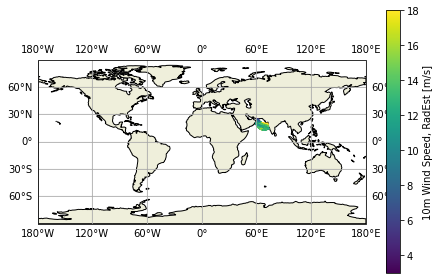

In [27]:
mapPlotScat(world_lons, world_lats, world_wind_radEst,
                 'World_wind_RadEst_Plat', 3,18)

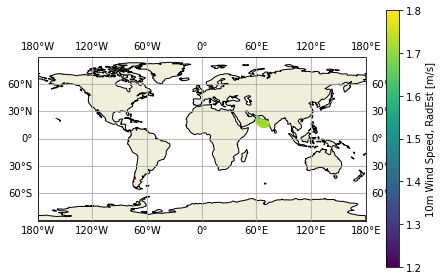

In [28]:
mapPlotScat(world_lons, world_lats, world_wind_err_radEst,
                 'World_wind_Err_RadEst_Plat',1.2,1.8)

In [ ]:
lats_radEst

In [ ]:
def get_TB_frame(BT_scene_env1, area_interest, begin_t, end_t):
    
    lat_scene1 = supporting_routines_m.generate_masked_array(BT_scene_env1.lat[begin_t:end_t,:],
                                                  BT_scene_env1.sft[begin_t:end_t,:], 0, '==', drop= False) 
    lon_scene1 = supporting_routines_m.generate_masked_array(BT_scene_env1.lon[begin_t:end_t,:],
                                                  BT_scene_env1.sft[begin_t:end_t,:], 0, '==', drop= False) 
    tb_scene1 = supporting_routines_m.generate_masked_array(BT_scene_env1.tb[begin_t:end_t,:,:],
                                                  BT_scene_env1.sft[begin_t:end_t,:], 0, '==', drop= False) 

    grid_lons_interest, grid_lats_interest = area_interest.get_lonlats()

    swath_scene1 = SwathDefinition(lons=lon_scene1, lats=lat_scene1)
    lons_scene1, lats_scene1 = swath_scene1.get_lonlats()

    reduced_lons_scene1, reduced_lats_scene1, reduced_data_scene1 = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_interest, grid_lats_interest,
                            lons_scene1, lats_scene1, tb_scene1.values,
                            radius_of_influence=3000)

    return reduced_lons_scene1, reduced_lats_scene1, reduced_data_scene1
    #swath_reduced_scene1 = SwathDefinition(reduced_lons_scene1, reduced_lats_scene1)

In [ ]:
def defineArea(corners, proj_id, datum):
    #corners=parseMeta(data_name)

    lat_0 = '{lat_0:5.2f}'.format_map(corners)
    lon_0= '{lon_0:5.2f}'.format_map(corners)
    lon_bbox = [corners['min_lon'],corners['max_lon']]
    lat_bbox = [corners['min_lat'],corners['max_lat']]
#    area_dict = dict(datum=datum,lat_0=lat_0,lon_0=lon_0,
#                proj=proj_id,units='m')

    area_dict = dict(datum=datum,lat_0=-15,lon_0=60,
                proj=proj_id,units='m',a=6370997.0,)

    prj=pyproj.Proj(area_dict)
    x, y = prj(lon_bbox, lat_bbox)
    xsize=200
    ysize=200
    area_id = 'granule'
    area_name = 'modis swath 5min granule'
    area_extent = (x[0], y[0], x[1], y[1])
    print(area_extent)
    area_def = AreaDefinition(area_id, area_name, proj_id, 
                                   area_dict, xsize, ysize,area_extent)
    return area_def

In [ ]:
# Creation of area of interest:
#corners = {"min_lon": 25 , "max_lon": 75, "min_lat": -30 , "max_lat": 0, "lat_0": 60, "lon_0":-15}
corners = {"min_lon": -95 , "max_lon": 20, "min_lat": 3 , "max_lat": 50, "lat_0": 27, "lon_0":-57}
proj_id = 'eqc'  # eqc
datum = 'WGS84'
area_interest = defineArea(corners, proj_id, datum)

In [ ]:

area_def_world = load_area('areas.yaml', 'worldeqc30km70')# 'worldeqc30km70') # for plots
grid_lons_world, grid_lats_world = area_def_world.get_lonlats()

In [ ]:
def timeMapAnimScat(BT_scene, BT_attributes, channel, area, 
                      init_date, nFrames, delta_hours, namefile):
    # Make a Mercator map of the data using Cartopy
    
    import matplotlib.animation as animation

    crs = area.to_cartopy_crs()
    
    #fig2 = plt.subplots(1,2) 
    fig = plt.figure(frameon=False) #figsize=(8, 6))
    fig.add_axes([0,0,1,1])
    ax = plt.axes(projection=crs)  
    ax.set_global()
    gl = ax.gridlines()  
    ax.set_title("TB "+namefile)
    #ax.set_title("Wind Speed "+namefile)
    
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black') 
    
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER 


    #delta_hours = 12
    end_date = init_date + np.timedelta64(delta_hours, 'h') 
    time_slice = np.where((BT_attributes.time.values>=init_date)&(
        BT_attributes.time.values<end_date))
    begin_t = time_slice[0][0]  
    end_t = time_slice[0][-1]

    x, y, data = get_TB_frame(BT_scene, area, begin_t, end_t)
    
    ims = []
    im1 = plt.scatter(
            x,
            y,
            c=data[:,channel],
            s=0.15,
            cmap="viridis",
            #transform=ccrs.PlateCarree(),
            #vmin=3, vmax=12     # 180, 270
            vmin=130, vmax=270     # 180, 270
        ) 
    
    #fig.colorbar(im1).set_label("10m Wind Speed [m/s]")
    #fig.colorbar(im1).set_label("Temp. Bright. [K]") 
    
    for i in np.arange(nFrames):

        im1 = plt.scatter(
            x,
            y,
            c=data[:,channel],
            s=0.15,
            cmap="viridis",
            transform=ccrs.PlateCarree(),
            #vmin=3, vmax=12  # 180, 270
            vmin=130, vmax=270  # 180, 270
        ) 
        
        ims.append([im1])
        init_date = init_date + np.timedelta64(delta_hours, 'h') 
        end_date = end_date + np.timedelta64(delta_hours, 'h') 
        time_slice = np.where((BT_attributes.time.values>=init_date)&(
            BT_attributes.time.values<end_date))
        begin_t = time_slice[0][0]  
        end_t = time_slice[0][-1] 
        x, y, data = get_TB_frame(BT_scene, area, begin_t, end_t)

        
    im_ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=3000,
                                   blit=True)
    # To save this second animation with some metadata, use the following command:
    # im_ani.save('im.mp4', metadata={'artist':'Guido'})
    plt.tight_layout()
    im_ani.save(namefile+'.mp4',dpi=150)
    plt.show()

In [ ]:
nFrames = 12
delta_hours = 12
channel = 2
namefile = 'env1_22V_12h_F16'
timeMapAnimScat(BT_scene, BT_attributes, channel, area_interest, 
                      init_date, nFrames, delta_hours, namefile)

In [ ]:
# Resample swath scene 1 at a world wide scale:

result_scene1 = resample_nearest(swath_scene1, tb_scene1.values, area_def_world, 
                          radius_of_influence=30000, fill_value=np.nan)

#result_scene2 = resample_nearest(swath_scene2, tb_scene2.values, area_def_world, 
#                          radius_of_influence=30000, fill_value=np.nan)

In [ ]:
# Mask out swath part that intersects the area of interest


#reduced_lons_scene2, reduced_lats_scene2, reduced_data_scene2 = \
#                           data_reduce.swath_from_lonlat_grid(grid_lons_interest, grid_lats_interest,
#                            lons_scene2, lats_scene2, tb_scene2.values,
#                            radius_of_influence=3000)
#swath_reduced_scene2 = SwathDefinition(reduced_lons_scene2, reduced_lats_scene2)

In [ ]:
# Mask out swath part that intersects the area of interest
world_lons_scene1, world_lats_scene1, world_data_scene1 = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_world, grid_lats_world,
                            lons_scene1, lats_scene1, tb_scene1.values,
                            radius_of_influence=3000)
swath_world_scene1 = SwathDefinition(reduced_lons_scene1, reduced_lats_scene1)

world_lons_scene2, world_lats_scene2, world_data_scene2 = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_world, grid_lats_world,
                            lons_scene2, lats_scene2, tb_scene2.values,
                            radius_of_influence=3000)
swath_world_scene2 = SwathDefinition(reduced_lons_scene2, reduced_lats_scene2)

In [ ]:
# Resample swath data into a grid in the area of interest 
result_reduced_scene1 = resample_nearest(swath_reduced_scene1, reduced_data_scene1, area_interest, 
                                  radius_of_influence=30000, fill_value=None)

result_reduced_scene2 = resample_nearest(swath_reduced_scene2, reduced_data_scene2, area_interest, 
                                  radius_of_influence=30000, fill_value=None)

In [ ]:
mapArea('mapArea0', area_def_world)
mapArea('mapArea01', area_interest)

In [ ]:
chann = 0
# Plot resampled (grid version) scenes:
basicMapPlot(result_scene1[:,:,chann],'scene1'+str(chann), area_def_world)  # map of the whole world, grid
basicMapPlot(result_reduced_scene1[:,:,chann],
             'scene1_reduced'+str(chann), area_interest)  # map only the area of interest, grid

basicMapPlot(result_scene2[:,:,chann],'scene2'+str(chann), area_def_world)  # map of the whole world, grid
basicMapPlot(result_reduced_scene2[:,:,chann],
             'scene2_reduced'+str(chann), area_interest)  # map only the area of interest, grid

In [ ]:
# Plot in area of interest, Plate Carree projection

chann = 0
# Plot original swath pixels:
basicMapPlotScat(reduced_lons_scene1, reduced_lats_scene1, reduced_data_scene1[:,chann],
                 'scene1_scatt_PCarr_19H', area_interest, )
chann = 1
# Plot original swath pixels:
basicMapPlotScat(reduced_lons_scene1, reduced_lats_scene1, reduced_data_scene1[:,chann],
                 'scene1_scatt_PCarr_19V', area_interest, )
chann = 2
# Plot original swath pixels:
basicMapPlotScat(reduced_lons_scene1, reduced_lats_scene1, reduced_data_scene1[:,chann],
                 'scene1_scatt_PCarr_22V', area_interest, )
#chann = 1
#basicMapPlotScat(reduced_lons_scene2, reduced_lats_scene2, reduced_data_scene2[:,chann],
#                 'scene2_scatt_PCarr_91V', area_interest)

In [ ]:
image_path = Path('/nobackup/users/echeverr/fortran_tests/netcdf/following_Edouard/imgs/ch19H')
images = list(image_path.glob('*.png'))
image_list = []
for file_name in images:
    image_list.append(imageio.imread(file_name))

In [ ]:
imageio.mimwrite('animated_from_images.gif', image_list)

In [ ]:
# Plot in world area, Orthographic projection

chann = 2
# Plot original swath pixels:
basicMapPlotScat1(reduced_lons_scene1, reduced_lats_scene1, reduced_data_scene1[:,chann],
                 'world_scene1_scatt_Orth_22V', area_interest)
#chann = 3
#basicMapPlotScat1(reduced_lons_scene2, reduced_lats_scene2, reduced_data_scene2[:,chann],
#                 'world_scene1_scatt_Orth_91H', area_interest)

In [ ]:
# Plot original swath pixels:
chann = 2
basicMapPlotScat1(world_lons_scene1, world_lats_scene1, world_data_scene1[:,chann],
                 'scene1_scatt_Orth_world_22V', area_def_world)
chann = 3
basicMapPlotScat1(world_lons_scene2, world_lats_scene2, world_data_scene2[:,chann],
                 'scene1_scatt_Orth_world_91H', area_def_world)

In [ ]:
def basicMapPlot(result,namefile, area):
    crs = area.to_cartopy_crs()
    fig, ax = plt.subplots(figsize=(13, 3))
    ax= plt.axes(projection=crs)
    #ax.background_img(name='BM', resolution='high') 
    ax.coastlines();
    #ax.stock_img();
    ax.grid(True)
    #ax.set_xlabel('Longitude [deg]')
    #ax.set_ylabel('Latitude [deg]')

    #gl = ax.gridlines(crs=ccrs.Orthographic(), linewidth=0.1, 
    #                  color='black', alpha=0.5, linestyle='--', draw_labels=True)
    #gl.xlabels_top = False
    #gl.ylabels_left = False
    #gl.ylabels_right=True
    #gl.xlines = True
    #gl.xlocator = mticker.FixedLocator([70, 75, 80, 85])
    #gl.ylocator = mticker.FixedLocator([-5, -3, -1, 1, 3])
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER

    im = ax.imshow(result, transform=crs, extent=crs.bounds, origin='upper', cmap='jet', vmin=150, vmax=250)
    fig.colorbar(im,ax=ax) 
    plt.savefig(namefile+'.png', bbox_inches='tight', dpi=150)  


In [ ]:
def basicMapPlotScat(x,y,data,namefile, area):
    # Make a Mercator map of the data using Cartopy
    
    crs = area.to_cartopy_crs()
    
    fig = plt.figure(figsize=(8, 6))
    #plt.figure(figsize=(8, 6))
    ax = plt.axes(projection=crs)   
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
    ax.set_global()
    ax.gridlines()        
    ax.set_title("TB")
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.1, 
                      color='black', alpha=0.5, linestyle='--', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER    

    # Plot the air temperature as colored circles and the wind speed as vectors.
    im = ax.scatter(
        x,
        y,
        c=data,
        s=0.15,
        cmap="viridis",
        transform=ccrs.PlateCarree(),
        #vmin=3, vmax=18         #180, 270
        vmin=130, vmax=270         #180, 270
    )
    fig.colorbar(im).set_label("Brightness temperature [K]")
    
# Use an utility function to add tick labels and land and ocean features to the map.

    plt.tight_layout()
    #plt.show()
    plt.savefig(namefile+'.png', bbox_inches='tight', dpi=150)  

In [ ]:
def mapArea(namefile, area):

    crs = area.to_cartopy_crs()
    fig, ax = plt.subplots(figsize=(13, 3))
    ax= plt.axes(projection=crs)
    
    #gl = ax.gridlines(crs=ccrs.Orthographic(), linewidth=0.1, 
    #                  color='black', alpha=0.5, linestyle='--', draw_labels=True)

    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
    
    ax.coastlines(linewidth=0.5)   
    #ax.set_global() 
    plt.savefig(namefile+'.png', bbox_inches='tight', dpi=300)  

In [ ]:
#chann = 0
#basicMapAnimScat(reduced_lons_scene2, reduced_lats_scene2, reduced_data_scene2[:,chann],
#                 'scene1_scatt'+str(chann), area_interest)

nFrames = 150
start_frame = 0
nAcrossSwathFrame = 180

chann = 0
basicMapAnimScat(reduced_lons_scene2, reduced_lats_scene2, reduced_data_scene2[:,chann],
                 'An_scene1_scatt_Orth_red_19H', area_interest, 
                  nFrames, start_frame, nAcrossSwathFrame)

chann = 2
basicMapAnimScat(reduced_lons_scene2, reduced_lats_scene2, reduced_data_scene2[:,chann],
                 'An_scene1_scatt_Orth_red_91V', area_interest, 
                  nFrames, start_frame, nAcrossSwathFrame)

chann = 2
basicMapAnimScat(reduced_lons_scene2, reduced_lats_scene2, reduced_data_scene2[:,chann],
                 'An_scene1_scatt_Orth_red_22V', area_interest, 
                  nFrames, start_frame, nAcrossSwathFrame)

chann = 3
basicMapAnimScat(reduced_lons_scene2, reduced_lats_scene2, reduced_data_scene2[:,chann],
                 'An_scene1_scatt_Orth_red_91H', area_interest, 
                  nFrames, start_frame, nAcrossSwathFrame)

In [ ]:
def basicMapAnimScat(x,y,data,namefile, area, 
                      nFrames, start_frame, nAcrossSwathFrame):
    # Make a Mercator map of the data using Cartopy
    
    import matplotlib.animation as animation

    crs = area.to_cartopy_crs()
    
    #fig2 = plt.subplots(1,2) 
    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes(projection=crs)  
    ax.set_global()
    gl = ax.gridlines()  
    #ax.set_title("TB "+namefile)
    ax.set_title("Wind Speed "+namefile)
    
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
   
    #gl0 = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.1, 
    #                  color='black', alpha=0.5, linestyle='--', draw_labels=True)

    #gl0.xformatter = LONGITUDE_FORMATTER
    #gl0.yformatter = LATITUDE_FORMATTER 
    
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER 
    
    start_ = start_frame
    end_ = nAcrossSwathFrame
    
    ims = []
    x2 = x[start_:end_]
    y2 = y[start_:end_]
    data2_0 = data[start_:end_]
    #data2_2 = data[start_:end_,2]

    im1 = plt.scatter(
            x2,
            y2,
            c=data2_0,
            s=0.15,
            cmap="viridis",
            #transform=ccrs.PlateCarree(),
            vmin=3, vmax=12     # 180, 270
            #vmin=130, vmax=270     # 180, 270
        ) 
    fig.colorbar(im1).set_label("10m Wind Speed [m/s]")
    #fig.colorbar(im1).set_label("Temp. Bright. [K]") 
    for i in np.arange(nFrames):
        #ims.append((plt.pcolor(x, y, base + add, norm=plt.Normalize(0, 30)),))

        im1 = plt.scatter(
            x2,
            y2,
            c=data2_0,
            s=0.15,
            cmap="viridis",
            transform=ccrs.PlateCarree(),
            vmin=3, vmax=12  # 180, 270
            #vmin=130, vmax=270  # 180, 270
        ) 

        ims.append([im1])
      
        
        start_ +=nAcrossSwathFrame
        end_ +=nAcrossSwathFrame
        x2 = np.append(x2,x[start_:end_])
        y2 = np.append(y2,y[start_:end_])
        data2_0 = np.append(data2_0,data[start_:end_])
        #data2_2 = np.append(data2_2,data[start_:end_,2])

        
    im_ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=3000,
                                   blit=True)
    # To save this second animation with some metadata, use the following command:
    # im_ani.save('im.mp4', metadata={'artist':'Guido'})
    im_ani.save(namefile+'_bar.mp4',dpi=150)
    plt.show()

In [ ]:
BT_scene_env2 

In [ ]:
def basicMapPlotScat1(x,y,data,namefile, area):
    # Make a Mercator map of the data using Cartopy
    
    fig = plt.figure()
    
    ortho = ccrs.Orthographic(60,-15)
    ax = plt.axes(projection=ortho)
    
    crs = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
    geo = ccrs.Geodetic()
    #crs = ccrs.Orthographic(60,-15)
    
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
    
    xy = ortho.transform_points(geo, x, y)

    ax.set_global()
    ax.gridlines()    
    
    #ax.set_title("TB")
    #ax.coastlines() 
    # Plot the air temperature as colored circles and the wind speed as vectors.
    im = ax.scatter(
        xy[:,0],
        xy[:,1],
        c=data,
        s=0.15,
        cmap="viridis",
        #transform=crs,
        #vmin=3, vmax=18,  # 180, 270
        vmin=130, vmax=270,  # 180, 270        
    )
    #fig.colorbar(im).set_label("10m Wind Speed, HOAPS [m/s]")
    fig.colorbar(im).set_label("Temp. Bright [K]")
    
# Use an utility function to add tick labels and land and ocean features to the map.

    plt.tight_layout()
    #plt.show()
    plt.savefig(namefile+'.png', bbox_inches='tight', dpi=300)  

In [ ]:
nFrames = 1200
start_frame = 0
nAcrossSwathFrame = 180

chann = 0
basicMapAnimScat1(world_lons_scene1, world_lats_scene1, world_data_scene1[:,chann],
                 'An_scene1_scatt_Orth_world_19H', area_interest, 
                  nFrames, start_frame, nAcrossSwathFrame)

chann = 2
basicMapAnimScat1(world_lons_scene2, world_lats_scene2, world_data_scene2[:,chann],
                 'An_scene1_scatt_Orth_world_91V', area_interest, 
                  nFrames, start_frame, nAcrossSwathFrame)

chann = 2
basicMapAnimScat1(world_lons_scene1, world_lats_scene1, world_data_scene1[:,chann],
                 'An_scene1_scatt_Orth_world_22V', area_interest, 
                  nFrames, start_frame, nAcrossSwathFrame)

chann = 3
basicMapAnimScat1(world_lons_scene2, world_lats_scene2, world_data_scene2[:,chann],
                 'An_scene1_scatt_Orth_world_91H', area_interest, 
                  nFrames, start_frame, nAcrossSwathFrame)

In [ ]:
def basicMapAnimScat1(x,y,data,namefile, area, 
                      nFrames, start_frame, nAcrossSwathFrame):
    # Make a Mercator map of the data using Cartopy
    
    import matplotlib.animation as animation

    fig = plt.figure(figsize=(8, 6))
    
    ortho = ccrs.Orthographic(-39,18) #ccrs.Orthographic(60,-15)
    ax = plt.axes(projection=ortho)
    
    crs = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
    geo = ccrs.Geodetic()
    
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
    
    xy = ortho.transform_points(geo, x, y)

    ax.set_global()
    ax.gridlines()        
       
    ax.set_title("Wind Speed "+namefile) 
    #ax.set_title("Temperature Brightness "+namefile) 
    
    start_ = start_frame
    end_ = nAcrossSwathFrame
    
    ims = []
    x2 = xy[start_:end_,0]
    y2 = xy[start_:end_,1]
    data2_0 = data[start_:end_]
    #data2_2 = data[start_:end_,2]

    im1 = plt.scatter(
            x2,
            y2,
            c=data2_0,
            s=0.15,
            cmap="viridis",
            #transform=ccrs.PlateCarree(),
            vmin=3, vmax=18  # 180, 250
            #vmin=130, vmax=270   # 180, 270 TB
        ) 
    fig.colorbar(im1).set_label("10m Wind Speed [m/s]")
    #fig.colorbar(im1).set_label("Temp. Bright. [K]") 
    for i in np.arange(nFrames):
        #ims.append((plt.pcolor(x, y, base + add, norm=plt.Normalize(0, 30)),))

        #plt.tight_layout()
        im1 = plt.scatter(
            x2,
            y2,
            c=data2_0,
            s=0.15,
            cmap="viridis",
            #transform=ccrs.PlateCarree(),
            vmin=3, vmax=18   # 180, 270 TB
            #vmin=130, vmax=270   # 180, 270 TB
        ) 

        ims.append([im1])
      
        
        start_ +=nAcrossSwathFrame
        end_ +=nAcrossSwathFrame
        x2 = np.append(x2,xy[start_:end_,0])
        y2 = np.append(y2,xy[start_:end_,1])
        data2_0 = np.append(data2_0,data[start_:end_])
        #data2_2 = np.append(data2_2,data[start_:end_,2])

        
    im_ani = animation.ArtistAnimation(fig, ims, interval=30, repeat_delay=3000,
                                   blit=True)
    # To save this second animation with some metadata, use the following command:
    # im_ani.save('im.mp4', metadata={'artist':'Guido'})
    im_ani.save(namefile+'.mp4',dpi=150)
    plt.show()